TODO:
-hyperparameter suche hinzufügen
-kommentare hinzufügen die sagen warum ich diese Schritte gehen und nicht andere nehme


# Deep Learning project: Face Recognition

The following notebook is about training a face recognition model with deep learning methods. For this purpose, an own dataset with face images is to be created. With these images different models should be trained and finally compared. The project is part of the [Deep Learning](https://ilias.hs-heilbronn.de/ilias.php?ref_id=20660&cmdClass=ilrepositorygui&cmdNode=xo&baseClass=ilrepositorygui) course at the University of Heilbronn and serves educational purposes.

---

**Author:**

Dominik Bücher, Hochschuhle Heilbronn, Automotive System Engineering Master

dbuecher@stud.hs-heilbronn.de


**Professor:**

Prof. Dr.-Ing. Nicolaj Stache 

nicolaj.stache@hs-heilbronn.de 

---



## Table of Contents

#### 1. [Introduction](#Introduction)
#### 2. [Import of Librarys](#Import)
#### 3. [Presenting the dataset](#dataset)
#### 4. [Import the dataset](#dataset2)
#### 5. [Data augmentation](#augmentation)
#### 6. [Models](#models)
#### 7. [Training](#training)
#### 8. [Evaluation](#eva)
#### 9. [Testing](#testing)
#### 10. [Live face recognition](#live)
#### 11. [Discussion of the results](#Conclusion)


## 1. Introduction <a id="Introduction"></a>

Before diving into the project's implementation details, let's start with a brief introduction. The objective of this project, as mentioned earlier, is to train a Deep Learning Model capable of recognizing and labeling faces. It is particularly crucial for the model to identify its own creator's face, namely Dominik Bücher, and correctly label it. Any other faces detected should be labeled as "Unknown." To accomplish this, transfer learning is utilized during the training process.

Transfer learning involves retraining a pre-existing model on new data. In this case, a model that has previously been trained on a vast number of images is retrained on a smaller dataset specific to this project. The key advantage of transfer learning is its ability to achieve impressive performance on novel tasks with limited data and computational resources. By leveraging the knowledge acquired during prior training, the model can learn more swiftly and efficiently.

This notebook primarily focuses on training and testing personalized models, offering invaluable hands-on experience in the field. As a result, instead of training a single model, the aim in this project is to train five distinct models. All of these models will utilize transfer learning, although each will have a different foundational model on which transfer learning is applied.

In accordance with the task instructions, the use of the VGG16 model for transfer learning is explicitly prohibited. However, due to its prior utilization in the lecture and the gathering of initial experiences, the VGG16 model is included in this project solely for the purpose of comparing the other models. Given the preliminary insights gained from working with this model, it proves highly suitable for evaluating the performance of the other customized models. Since it is clearly forbidden by the task to use this model, it is clarified here that the model is only used to compare the other models. Furthermore, it is important to highlight that the main focus of this project is directed towards the training and evaluation of the other models. However, the specific details regarding the models involved, as well as the training and testing procedures, will be discussed in a later chapter.

As can be seen from the Table of Contents, the data set on which the models are trained is presented at the beginning of the project. Subsequently, this data set is imported and a data augmentation is performed on the images.

![image.png](data/test/Dominik/image_0.jpg)

## 2. Import of Librarys <a id="Import"></a>

In [2]:
%pip install fast_ml
%pip install -U efficientnet
%pip install cv2

  Using cached fast_ml-3.68-py3-none-any.whl (42 kB)
Note: you may need to restart the kernel to use updated packages.
  Using cached efficientnet-1.1.1-py3-none-any.whl (18 kB)
  Using cached Keras_Applications-1.0.8-py3-none-any.whl (50 kB)
  Using cached lazy_loader-0.2-py3-none-any.whl (8.6 kB)
  Using cached networkx-3.1-py3-none-any.whl (2.1 MB)
  Using cached tifffile-2023.4.12-py3-none-any.whl (219 kB)
  Using cached PyWavelets-1.4.1-cp39-cp39-win_amd64.whl (4.2 MB)
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


ERROR: Could not find a version that satisfies the requirement cv2 (from versions: none)
ERROR: No matching distribution found for cv2


In [48]:
# import the necessary packages
import os
import zipfile
# import matplotlib as plt
import matplotlib.pyplot as plt
import cv2
import glob
import tensorflow as tf

# from pyimagesearch.resnet import ResNet
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dropout
from tensorflow.keras.callbacks import EarlyStopping
from keras.preprocessing.image import img_to_array, array_to_img
from matplotlib import pyplot
import efficientnet.keras as efn

from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications import ResNet50, ResNet101, ResNet152, InceptionV3
import numpy as np
from PIL import Image
from PIL import Image, ImageOps
from keras.models import load_model


## 3. Presenting the dataset <a id="dataset"></a>

As mentioned in the introduction, this chapter introduces the data set that will be used later to train the models. Since the dataset is very crucial for the training, it is described here in as much detail as possible.

The dataset used is a self-created dataset which was created for this project. Since the objective is to recognize the face of Dominik Bücher, the dataset only requires two classes. One class contains images of Dominik, while the other class serves as a reference and is labeled as "Unknown." The "Unknown" class primarily ensures that the models are not trained in a biased manner and that a reference point is available. The images in the class consist of friends and family members of Dominik.

Specifically, a deliberate effort was made to include a diverse range of individuals in the "Unknown" class to prevent the model from overly focusing on a single additional face. By incorporating numerous different individuals within the "Unknown" class, the model is encouraged to develop a more generalized understanding of what constitutes an unknown face, rather than being biased towards specific individuals.

The dataset comprises a total of 450 images, with 300 images belonging to the Dominik class and 150 images belonging to the Unknown class. The images used predominantly consist of facial images. Special attention was given to including a diverse range of facial expressions and angles of Dominik's face within the Dominik class. A small selection of example images from the Dominik class can be observed in the following figures:

![dominik1.png](Bilder-notebook\Dominik1.PNG)

![dominik2.png](Bilder-notebook\Dominik2.PNG)

The images were carefully selected to include various angles of the face, ensuring a comprehensive representation. Furthermore, in order to introduce a certain level of variance, different outfits were used in the photographs. Additionally, lighting conditions and backgrounds were altered to add diversity to the dataset. These measures help to enhance the model's ability to generalize and perform well in real-world scenarios with varying conditions. The images also vary in terms of facial expressions to include images where various facial expressions, including grimaces, are captured. This allows the model to recognize and classify images with different facial expressions.

Since the Unknown class serves as a reverence, it is not important to have many different images of one face, but many different images of other faces. It also happens that there is no face at all, so that the model can cope with such images. Below are a number of example images from the Unknown class:

![Unknown1.png](Bilder-notebook\Unknown1.PNG)

![Unknown2.png](Bilder-notebook\Unknown2.PNG)

Based on the examples of the images from the two classes, it is clear that the images from Dominik's class usually have a better quality or resolution. This is because the value of these images is clearly more important and care was taken to ensure that they have a reasonably satisfactory quality. Whereas the images of the Unknown class had no quality requirements.

**Size of the dataset:**                                          
Coming back to the amount of images in the dataset, this was not chosen purely randomly. First of all, it should be noted that transfer learning does not require a large dataset, which is one of the advantages of this method. Therefore, it is clear why the dataset used does not contain thousands of images. However, it should not be too few, so that the models can learn the features of Dominik's face correctly. For this reason, the size of the dataset was experimented with in the beginning. Thereby it often came to problems if too few images were available for the training. This was due to the fact that the dataset is divided into training, validation and test data, leaving only a few images for training. Therefore, some epochs were canceled from time to time because there were too few images available. For this reason, and through some testing, it was determined that the dataset should contain at least a few hundred images so that sufficient images are also available for validation and testing. Therefore, since the dataset should still remain as small as possible, 300 images were chosen for the Dominik class. For the Unknown class only 150 images were chosen, since these images are not so important and it could be saved thus somewhat at storage place than if again 300 images would be used.

**Quality of the images:**                                                 
The images in the Dominik class were captured using an iPhone 12, ensuring a high-quality output. However, this also means that the 300 images consume significantly more memory than the maximum available 300 MB. Consequently, a decision was made to reduce the image quality by approximately 50%. This reduction decreased the data size from around 1.65 MB per image to 350 KB. Despite this adjustment, the image quality remains sufficiently good for training the models, as evident in the provided examples. Therefore, the initial high quality plays only a partial role for the training.

**Dataset structure:**                                                      
This section covers the dataset's structure, starting with an explanation of the initial folder structure, followed by the folder structure utilized after loading the dataset.

As depicted in the following figure, the dataset is divided into two folders, representing the distinct classes, with each folder aptly named accordingly. Within each class folder, only images belonging to that particular class are contained. By organizing the dataset in this manner, it becomes easier to navigate and access the images based on their respective classes.

Initial folder structure:
```
- face_dataset
    |- Dominik 
        |- image_0.jpeg
        |- image_1.jpeg
        |- image_2.jpeg
        |- ...
    |- Unknown
        |- image_0.jpeg
        |- image_1.jpeg
        |- image_2.jpeg
        |- ...
```

The goal is to store the dataset in a structure as depicted below. There will be three top-level folders containing images for training, validation, and testing, respectively. Within these three folders, there will always be two subfolders representing the two classes.

It is worth mentioning that additional images will be augmented later on, and these augmented images will also be incorporated into the same folder structure.



Folder structure for further processing:
```
- data
    |-train
        |- Dominik 
            |- image_0.jpeg
            |- image_1.jpeg
            |- image_2.jpeg
            |- ...
        |- Unknown
            |- image_0.jpeg
            |- image_1.jpeg
            |- image_2.jpeg
            |- ...
    |-validation
        |- Dominik 
            |- image_0.jpeg
            |- image_1.jpeg
            |- image_2.jpeg
            |- ...
        |- Unknown
            |- image_0.jpeg
            |- image_1.jpeg
            |- image_2.jpeg
            |- ...
    |-test
        |- Dominik 
            |- image_0.jpeg
            |- image_1.jpeg
            |- image_2.jpeg
            |- ...
        |- Unknown
            |- image_0.jpeg
            |- image_1.jpeg
            |- image_2.jpeg
            |- ...
```

## 4. Import the dataset <a id="dataset2"></a>

Now that the general procedure and the data set have been presented, we can start with the implementation. For this, the data set is first loaded from a ZIP file into a temporary directory so that it can be processed later. 

To accomplish this, you need to specify the path to the ZIP file and then combine it with the folder path. Once the dataset is stored in the temporary directory, you can easily access the two folders that contain the images for the two classes. Subsequently, the paths of these images are extracted and compiled into a list. These paths can then be utilized to conveniently access the corresponding images.

In [2]:
################ Unzip the dataset in the Colab runtime ##################

# Specify the path to the ZIP file containing the face dataset
zip_file_path = 'data/face_dataset.zip'

# Combine the path with the ZIP file
path_to_zip = os.path.join(zip_file_path)

# Print a message indicating the file being unzipped
print("Unzipping {}".format(path_to_zip))

# Specify the path where the extracted data will be stored
path_to_data = "/tmp"

# Open the ZIP file and extract its contents to the specified path
with zipfile.ZipFile(path_to_zip, 'r') as zip_ref:
    zip_ref.extractall(path_to_data)

# Retrieve the paths of the images for 'Dominik' and 'Unknown' categories
data_dominik = glob.glob(os.path.join(path_to_data, "face_dataset/Dominik/" + "*.jpeg"))
data_unknown = glob.glob(os.path.join(path_to_data, "face_dataset/Unknown/" + "*.jpeg"))

# Print the number of image paths found for 'Dominik' and 'Unknown' categories
print("Dominik: {} image paths".format(len(data_dominik)))
print("Unknown: {} image paths".format(len(data_unknown)))


Unzipping data/face_dataset.zip
Dominik: 300 image paths
Unknown: 150 image paths


Based on the output of the previous block, it is evident that all 450 images have been successfully located. However, if this is not the case and there are any errors, it is crucial to address and rectify them before proceeding with any further actions.

The number of found images of the two classes are visually represented in the following with this representation. This representation will be used several times in the following to show the development of the data set after the various preprocessing steps.

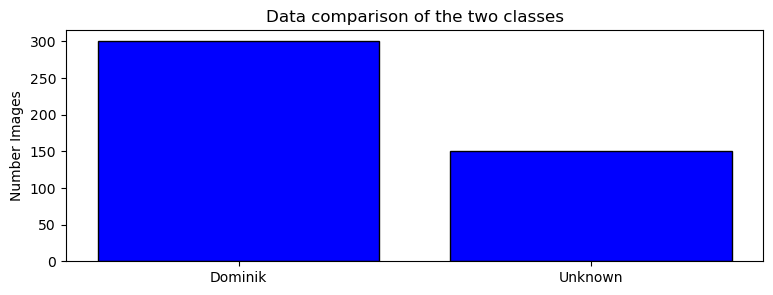

In [3]:
# Create a list of class names
names = ['Dominik', 'Unknown']

# Create a list of values representing the number of images in each class
values = [len(data_dominik), len(data_unknown)]

plt.figure(figsize=(9, 3)) # Set up the figure size for the bar chart
plt.bar(names, values, color='blue', edgecolor='black') # Create a bar chart with the class names as x-axis labels and the values as bar heights
plt.ylabel('Number Images') # Set the label for the y-axis
plt.title('Data comparison of the two classes') # Set the title of the chart
plt.show() # Display the chart


In the following code section the images are now loaded with the PIL library as PIL images into the runtime. After this step it is possible to edit the images as desired. 

As mentioned before, the images have to be resized again, this is also done in this block. For this the images are scaled down to the format of 224x224 pixels. The 224x224 pixels are a standard size on which most models are trained. Therefore, this format is also chosen for the images in this project.

After these operations, two arrays containing images of the respective class are obtained, and these images are in the PIL image format, each having a dimension of 224x224 pixels.

In [4]:
### Resizing the image of both classes
# Create an empty list to store the resized images for the 'Dominik' class
images_dominik = []

# Iterate over each JPEG file in the '/tmp/face_dataset/Dominik/' directory
for filename in glob.glob("/tmp/face_dataset/Dominik/" + "*.jpeg"):
    
    # Open the image file using PIL's Image module
    im = Image.open(filename)   
    # Perform any necessary image orientation adjustment using ImageOps.exif_transpose
    # This is need because the image are sometimes roted while saving
    im = ImageOps.exif_transpose(im)  
    # Resize the image to a target size of 224x224 pixels
    resized_im = im.resize([224, 224]) 
    # Append the resized image to the 'images_dominik' list
    images_dominik.append(resized_im)

# Print the number of resized images for the 'Dominik' class
print("Dominik list:", len(images_dominik))
# Print the first resized image in the 'images_dominik' list
print(images_dominik[0])


# Create an empty list to store the resized images for the 'Unknown' class
images_unknown = []

# Iterate over each JPEG file in the '/tmp/face_dataset/Unknown/' directory
for filename in glob.glob("/tmp/face_dataset/Unknown/" + "*.jpeg"):
   
    # Open the image file using PIL's Image module
    im = Image.open(filename)
    # Perform any necessary image orientation adjustment using ImageOps.exif_transpose
    # This is need because the image are sometimes roted while saving
    im = ImageOps.exif_transpose(im)
    # Resize the image to a target size of 224x224 pixels
    resized_im = im.resize([224, 224])
    # Append the resized image to the 'images_unknown' list
    images_unknown.append(resized_im)


# Print the number of resized images for the 'Unknown' class
print("Unknown list:", len(images_unknown))
# Print the first resized image in the 'images_unknown' list
print(images_unknown[0])



Dominik list: 300
<PIL.Image.Image image mode=RGB size=224x224 at 0x1B713BCEF10>
Unknown list: 150
<PIL.Image.Image image mode=RGB size=224x224 at 0x1B71E2C4CD0>


#### **Show examples of the imported images:**                                        
Now that the data is in the PIL format, we can proceed to output it. The following two code blocks will display a selection of sample images from the imported data. The first block will show images from the "Dominik" class, while the second block will display images from the "Unknown" class.

In [84]:
def printImages(images):
    for i in range(0,6,3):
        # Create a figure and axes
        fig, ax = plt.subplots(1,3, figsize=(8, 4))

        # Display the image
        ax[0].imshow(images[i])
        ax[1].imshow(images[i+5+1])
        ax[2].imshow(images[i+10+2])

        # Add a legend
        legend_text = ""
        ax[0].text(10, 10, legend_text, color='white', backgroundcolor='black')
        ax[1].text(10, 10, legend_text, color='white', backgroundcolor='black')
        ax[2].text(10, 10, legend_text, color='white', backgroundcolor='black')
        # ax[2].text(10, 10, legend_text, color='white', backgroundcolor='black')
        
        # Remove the axis labels
        ax[0].axis("off")
        ax[1].axis("off")
        ax[2].axis("off")
        
        # Adjust the layout
        plt.tight_layout()

        # Show the plot
        plt.show()

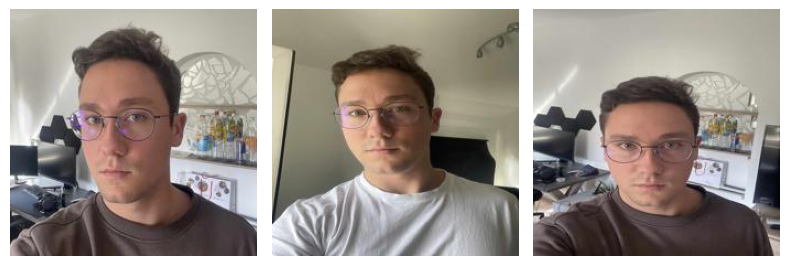

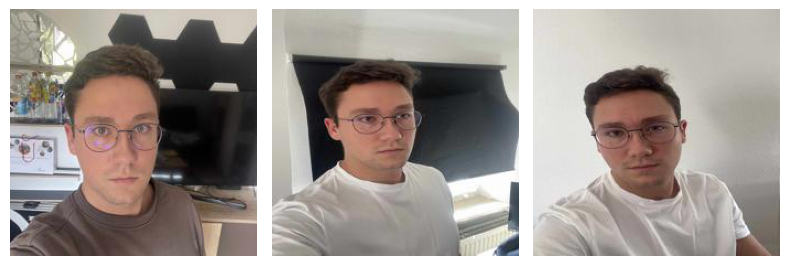

In [85]:
printImages(images_dominik)

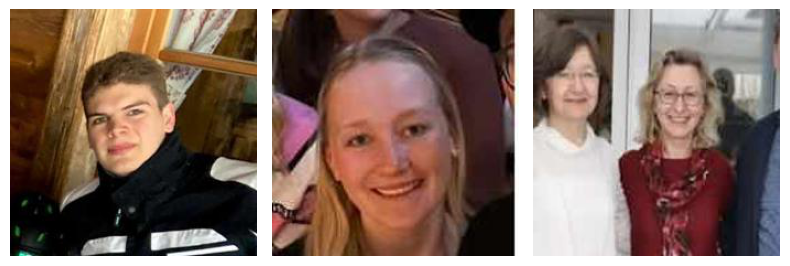

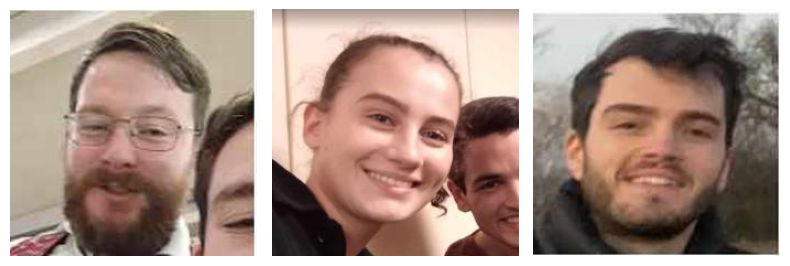

In [86]:
printImages(images_unknown)

#### **Normalize images:**
In this step the images are normalized and written into a new array. The purpose of normalizing images before training is to ensure consistency and improve the effectiveness of the training process. Normalization involves transforming pixel values to a standardized range. The benefits of image normalization include maintaining a consistent scale, faster convergence during training, addressing feature correlation, and promoting generalization to unseen data.

Alternatively, it would have been possible to perform the image normalization step directly after resizing the images. However, it was intentionally deferred to a later stage in order to provide clarity and emphasize the individual steps involved in the data processing pipeline.

In [14]:
# Create an empty list to store the normalized images for the 'Dominik' class
images_dominik_norm = []

# Iterate over each resized image in the 'images_dominik' list
for i in range(len(images_dominik)):
    # Convert the resized image to an array
    temp_data = img_to_array(images_dominik[i])
    # Normalize the image array using cv2.normalize, scaling the values between 0 and 1
    img_norm = cv2.normalize(temp_data, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
    # Convert the normalized array back to an image and append it to the 'images_dominik_norm' list
    images_dominik_norm.append(array_to_img(img_norm))

# Print the number of normalized images for the 'Dominik' class
print("Dominik normalized list:", len(images_dominik_norm))
# Print the first normalized image in the 'images_dominik_norm' list
print(images_dominik_norm[0])


# Create an empty list to store the normalized images for the 'Unknown' class
images_unknown_norm = []

# Iterate over each resized image in the 'images_unknown' list
for i in range(len(images_unknown)):
    # Convert the resized image to an array
    temp_data = img_to_array(images_unknown[i])
    # Normalize the image array using cv2.normalize, scaling the values between 0 and 1
    img_norm = cv2.normalize(temp_data, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
    # Convert the normalized array back to an image and append it to the 'images_unknown_norm' list
    images_unknown_norm.append(array_to_img(img_norm))

# Print the number of normalized images for the 'Unknown' class
print("Unknown normalized list:", len(images_unknown_norm))
# Print the first normalized image in the 'images_unknown_norm' list
print(images_unknown_norm[0])


Dominik normalized list: 300
<PIL.Image.Image image mode=RGB size=224x224 at 0x1B72B3CBBB0>
Unknown normalized list: 150
<PIL.Image.Image image mode=RGB size=224x224 at 0x1B71E2097F0>


#### **Split the dataset:**                      
As previously mentioned, the data must be split into a training, validation, and testing data set. This is very important to ensure effective model training, evaluation, and performance estimation. The training subset is used for model learning, the validation subset helps fine-tune the model and assess its performance during training, and the testing subset provides an unbiased evaluation of the final model's ability to generalize to unseen data. This process aids in preventing overfitting, obtaining reliable performance estimates, and building robust models capable of handling real-world scenarios.

The dataset can be efficiently split using the train_test_split() function, which requires the images and a corresponding list of labels as input. To create the labels list, you can generate two separate lists, each containing the class name for every image within that class. Since images within an array belong to the same class, this approach simplifies label creation. In addition to the images and labels, train_test_split() expects a value between 0 and 1, representing the desired data split ratio. In this case, a 70% portion is designated for the training dataset, which is a commonly used default value for such splits. The remaining 30% is then allocated for the validation and testing datasets.

Subsequently, the remaining 30% of the total data is further divided into validation and test datasets. For this partitioning, 60% of the remaining data is assigned to the validation dataset, while the remaining 40% is assigned to the test dataset.

These split ratios fall within the standard range commonly used for such divisions, making them suitable choices. However, it was decided to have a larger validation dataset than the test dataset due to insufficient validation data in some previous runs. Therefore, the split was adjusted to 60% for validation and 40% for testing. This change ensures that there is enough validation data available for reliable evaluation and effective fine-tuning of the model.

In [15]:
# Create empty lists to store the labels for the 'Unknown' and 'Dominik' classes
y_unknown = []
y_dominik = []

# Append 'unknown' labels to the 'y_unknown' list for each normalized image in the 'images_unknown_norm' list
# This is needed for the 'train_test_split' function -> every image needs a lable
for i in range(len(images_unknown_norm)):
    y_unknown.append('unknown')

# Append 'Dominik' labels to the 'y_dominik' list for each normalized image in the 'images_dominik_norm' list
# This is needed for the 'train_test_split' function -> every image needs a lable
for i in range(len(images_dominik_norm)):
    y_dominik.append('Dominik')

# Split the 'Unknown' class data into training and remaining datasets using train_test_split
X_train_unknown, X_rem_unknown, y_train_unknown, y_rem_unknown = train_test_split(images_unknown_norm, y_unknown, train_size=0.7)
# Split the 'Dominik' class data into training and remaining datasets using train_test_split
X_train_dominik, X_rem_dominik, y_train_dominik, y_rem_dominik = train_test_split(images_dominik_norm, y_dominik, train_size=0.7)

# Split the remaining 'Unknown' data into validation and test datasets using train_test_split
X_valid_unknown, X_test_unknown, y_valid_unknown, y_test_unknown = train_test_split(X_rem_unknown, y_rem_unknown, test_size=0.4)
# Split the remaining 'Dominik' data into validation and test datasets using train_test_split
X_valid_dominik, X_test_dominik, y_valid_dominik, y_test_dominik = train_test_split(X_rem_dominik, y_rem_dominik, test_size=0.4)


To provide a visual representation of the sizes of the individual datasets, the following diagram depicts the three datasets along with the distribution of the two classes within the dataset.

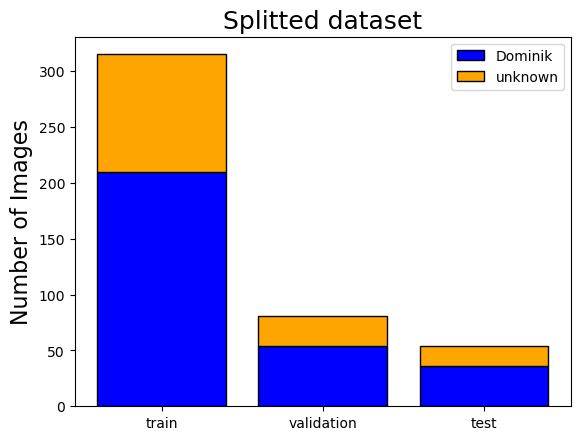

In [16]:
# Define the splits and data origins
split = ['train', 'validation', 'test']
data_origin = ['Dominik', 'unknown']

# Create an array of positions for the bars
pos = np.arange(len(split))

# Create lists of values for the 'Dominik' class for each split
values_dominik = [len(X_train_dominik), len(X_valid_dominik), len(X_test_dominik)]
# Create lists of values for the 'unknown' class for each split
values_unknown = [len(X_train_unknown), len(X_valid_unknown), len(X_test_unknown)]

# Create a bar plot for the 'Dominik' class
plt.bar(pos, values_dominik, color='blue', edgecolor='black')
# Create a bar plot for the 'unknown' class, stacking on top of the 'Dominik' class
plt.bar(pos, values_unknown, color='orange', edgecolor='black', bottom=values_dominik)
# Set the x-axis ticks to the split names
plt.xticks(pos, split)
# Set the y-axis label
plt.ylabel('Number of Images', fontsize=16)
# Set the title of the plot
plt.title('Splitted dataset', fontsize=18)
# Add a legend to differentiate the data origins
plt.legend(data_origin)
# Display the plot
plt.show()

**Create a directory for the dataset:**                       
To prepare for the training process, two directories are required: one for the training images and another for the validation images. Therefore, the following code blocks demonstrate the organization of the images into separate folders for each class within the training, validation, and testing datasets.

In [17]:
# Save the 'Unknown' class training images
for i in range(len(X_train_unknown)):
    X_train_unknown[i].save(r'data\train\unknown\image_' + str(i) + '.jpg', 'JPEG')

# Save the 'Unknown' class validation images
for i in range(len(X_valid_unknown)):
    X_valid_unknown[i].save(r'data\validation\unknown\image_' + str(i) + '.jpg', 'JPEG')

# Save the 'Unknown' class test images
for i in range(len(X_test_unknown)):
    X_test_unknown[i].save(r'data\test\unknown\image_' + str(i) + '.jpg', 'JPEG')

In [18]:
# Save the 'Dominik' class training images
for i in range(len(X_train_dominik)):
    X_train_dominik[i].save(r'data\train\Dominik\image_' + str(i) + '.jpg', 'JPEG')

# Save the 'Dominik' class validation images
for i in range(len(X_valid_dominik)):
    X_valid_dominik[i].save(r'data\validation\Dominik\image_' + str(i) + '.jpg', 'JPEG')

# Save the 'Dominik' class test images
for i in range(len(X_test_dominik)):
    X_test_dominik[i].save(r'data\test\Dominik\image_' + str(i) + '.jpg', 'JPEG')

## 5. Data augmentation <a id="augmentation"></a>

After successfully loading the images into memory and preprocessing them to a point where they are ready for training in their respective directories, we can now begin with data augmentation.

Data augmentation refers to the process of artificially expanding the dataset by applying various transformations to the existing images. These transformations can include rotation, scaling, flipping, cropping, or color changes, among others. By applying data augmentation techniques, we can make the dataset more diverse, better preparing the model to handle different variations of input data. This helps improve model generalization and reduces overfitting. It is important to carefully choose data augmentation techniques to maintain the realism of the images and consider the relevance of the transformations for the specific application domain.

But there are also downsides for data augmentation, for example having to much augmented images can lead to issues such as overfitting, increased computational costs, unrealistic representations, and confusion for the model. It is important to strike a balance in data augmentation, considering the dataset's characteristics and the desired generalization ability of the model. Applying moderate and meaningful augmentation techniques can enhance model performance without introducing the drawbacks associated with excessive augmentation.
For this reason, each image is augmented only once during data augmentation, even though it would be possible to generate many more augmented images. This approach helps prevent overfitting and maintains the realism of the data. By augmenting each image once, a moderate variation of the existing images is achieved, improving the model's robustness and preparing it for various scenarios

Before the images can be augmented, they need to be transformed into arrays. This conversion is necessary to enable efficient processing and manipulation of the image data. In addition, data augmentation typically requires an additional dimension in the array structure. To accommodate this requirement, each array is expanded by adding an extra dimension with a value of 0. This is done in the follwing block:

In [19]:
# Convert images to arrays and expand dimensions for the 'Unknown' class training and validation sets
train_unknown_array = []
for i in range(len(X_train_unknown)):
    train_unknown_array.append(np.expand_dims(img_to_array(X_train_unknown[i]), axis=0))

valid_unknown_array = []
for i in range(len(X_valid_unknown)):
    valid_unknown_array.append(np.expand_dims(img_to_array(X_valid_unknown[i]), axis=0))


# Convert images to arrays and expand dimensions for the 'Dominik' class training and validation sets
train_dominik_array = []
for i in range(len(X_train_dominik)):
    train_dominik_array.append(np.expand_dims(img_to_array(X_train_dominik[i]), axis=0))

valid_dominik_array = []
for i in range(len(X_valid_dominik)):
    valid_dominik_array.append(np.expand_dims(img_to_array(X_valid_dominik[i]), axis=0))


##### **Create the ImageDataGenerator:**
In this block, the actual data augmentation takes place using the ImageDataGenerator() function. This function is a powerful tool provided by TensorFlow that allows for real-time data augmentation during model training. In this case, however, augmentation is performed before training so that the resulting images can be stored and analyzed. Otherwise, it would not be possible to review the images before the training.

The ImageDataGenerator() function can be customized by passing various parameters to control the augmentation process. Here are the parameters that are used in this example:

- rotation_range: Specifies the range, in degrees, within which the images can be randomly rotated.
  - Normally this value of the rotation_range is between 0 and 45°, but since the images should not deviate too much from the real images (Setting a very high rotation range can introduce unnatural or implausible rotations that may not reflect real-world scenarios), it is set to 20° in this case. 
- width_shift_range: Defines the range, as a fraction of the total width, within which the images can be randomly shifted horizontally.
  - The width_shift_range parameter was set to 0.2. Since there is only one face in the center of the images, it does not matter much if the image is shifted by up to 20%, since no information is lost at the edges.
- height_shift_range: Specifies the range, as a fraction of the total height, within which the images can be randomly shifted vertically.
  - For the height_shift_range the same applies as for the width_shift_range parameter.
- zoom_range: Specifies the range for random zooming in or out of the images.
  - A zoom_range value of 0.2 is chosen to enhance the visibility of facial features in the augmented images. This allows the model to focus more prominently on the details of the face by zooming in on the image.
- horizontal_flip: Enables random horizontal flipping of the images.
  - The horizontal_flip parameter is set to True in order to introduce more variance and increase the diversity of the training data.
- vertical_flip: Enables random vertical flipping of the images.
  - The vertical_flip is set to False because otherwise there are images where the face is displayed upside down.
- brightness_range: Defines the range for randomly adjusting the brightness of the images.
  - The brightness_range is between [0.4, 1.2], these are default values. This makes the image neither too bright nor too dark.
- fill_mode: Specifies the strategy for filling in newly created pixels during image transformations.
  - The fill_mode is set to 'reflect', so the edges that would normally be black when moving the images are filled with the reflected image to simulate a natural transition.

By applying these augmentation parameters, the ImageDataGenerator() function can dynamically generate augmented images.

(TensorFlow. "ImageDataGenerator Class - TensorFlow API." Accessed July 18, 2023. URL: https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator)

In [76]:
# Data augmentation parameters
rotation_range = 20
width_shift_range = 0.2
height_shift_range = 0.2
zoom_range = 0.2
brightness_range = [0.4, 1.2]
fill_mode = 'reflect'

# Data augmentation for the 'Unknown' class training and validation sets
datagen = ImageDataGenerator(width_shift_range=width_shift_range, height_shift_range=height_shift_range, vertical_flip=False, horizontal_flip=True, rotation_range=rotation_range, brightness_range=brightness_range, zoom_range=zoom_range, fill_mode=fill_mode)

##### **Create the augmented data:**
After the ImageDataGenerator has been created with the previously mentioned parameters, separate loops are run through for the training and validation data of the two classes, in which the augmentation takes place. In each of these four loops, an augmented image is created from each training and validation image. These are then saved directly into the corresponding folders after a normailization. It should be noted that no images of the test dataset are specifically augmented here to ensure the integrity and representativeness of the test dataset. The test dataset is used to evaluate and validate the actual performance of the model on unknown data.

If test images are also augmented, this could lead to overrepresentation of certain augmentation patterns and bias the evaluation of the model. Test data should reflect reality as closely as possible to evaluate the performance of the model in a real environment.

In [79]:
images_train_aug_dominik = []
images_val_aug_dominik = []
images_train_aug_unknown = []
images_val_aug_unknown = []

# Generate augmented images for the 'Dominik' class training set
for i in range(len(train_dominik_array)):
    train_generator_dominik = datagen.flow(train_dominik_array[i], batch_size=1)
    # Generate a batch of augmented images
    batch = train_generator_dominik.next()
    # normalize the generated images
    img_norm = cv2.normalize(batch[0], None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
    im = array_to_img(img_norm)
    images_train_aug_dominik.append(im)
    # save the augmented images in the same folder as the original images of the Dominik class
    im.save(r'data\train\Dominik\augmented_image_' + str(i) + '.jpg')

# Generate augmented images for the 'Dominik' class validation set
for i in range(len(valid_dominik_array)):
    valid_generator_dominik = datagen.flow(valid_dominik_array[i], batch_size=1)
    # Generate a batch of augmented images
    batch = valid_generator_dominik.next()
    # normalize the generated images
    img_norm = cv2.normalize(batch[0], None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
    im = array_to_img(img_norm)
    images_val_aug_dominik.append(im)
    # save the augmented images in the same folder as the original images of the Dominik class
    im.save(r'data\validation\Dominik\augmented_image_' + str(i) + '.jpg')

# Generate augmented images for the 'Unknown' class training set
for i in range(len(train_unknown_array)):
    train_generator_unknown = datagen.flow(train_unknown_array[i], batch_size=1)
    # Generate a batch of augmented images
    batch = train_generator_unknown.next()
    # normalize the generated images
    img_norm = cv2.normalize(batch[0], None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
    im = array_to_img(img_norm)
    images_train_aug_unknown.append(im)
    # save the augmented images in the same folder as the original images of the unknown class
    im.save(r'data\train\unknown\augmented_image_' + str(i) + '.jpg')

# Generate augmented images for the 'Unknown' class validation set
for i in range(len(valid_unknown_array)):
    valid_generator_unknown = datagen.flow(valid_unknown_array[i], batch_size=1)
    # Generate a batch of augmented images
    batch = valid_generator_unknown.next()
    # normalize the generated images
    img_norm = cv2.normalize(batch[0], None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
    im = array_to_img(img_norm)
    images_val_aug_unknown.append(im)
    # save the augmented images in the same folder as the original images of the unknown class
    im.save(r'data\validation\unknown\augmented_image_' + str(i) + '.jpg')

##### **Visualize the results:**
The following code blocks showcase sample images from the training and validation data sets of the two classes. These images demonstrate the various transformations applied using the specified augmentation parameters. Some transformations may appear more pronounced, while others may be subtle. However, it is evident that the images have undergone modifications. 

Augmented images of the class Dominik and the dataset train: 


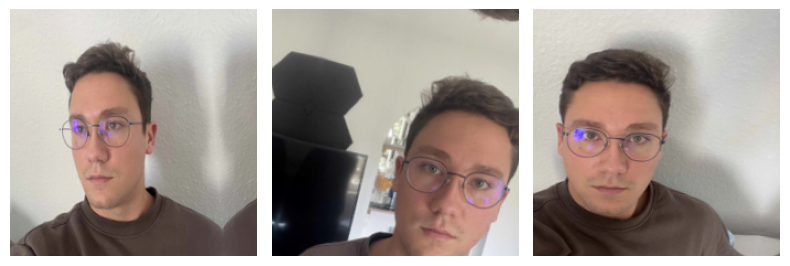

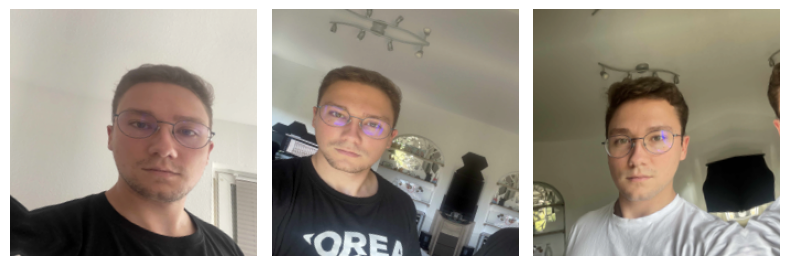

In [87]:
# print some example images
print("Augmented images of the class Dominik and the dataset train: ") 
# Call the function to print the augmented images in the training dataset for the class "Dominik"
printImages(images_train_aug_dominik)

Augmented images of the class Dominik and the dataset validation: 


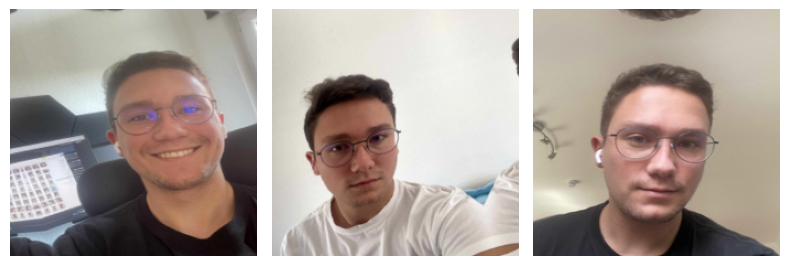

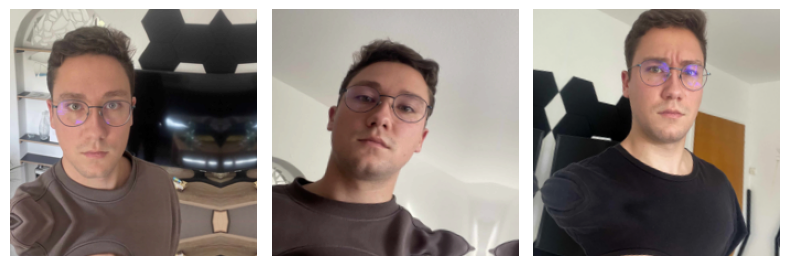

In [88]:
# print some example images
print("Augmented images of the class Dominik and the dataset validation: ")
# Call the function to print the augmented images in the validation dataset for the class "Dominik" 
printImages(images_val_aug_dominik)

Augmented images of the class Dominik and the dataset train: 


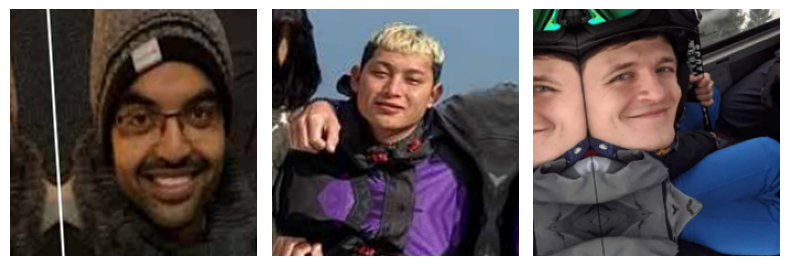

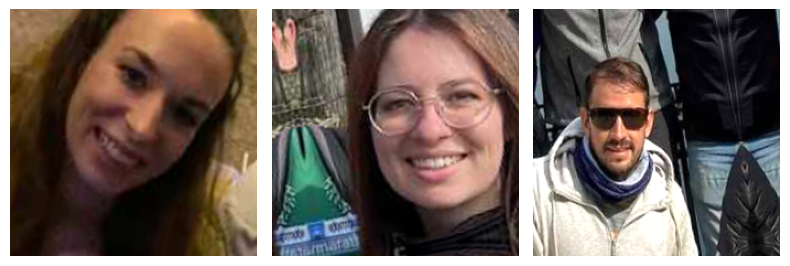

In [89]:
# print some example images
print("Augmented images of the class Dominik and the dataset train: ")
# Call the function to print the augmented images in the training dataset for the class "Unknown" 
printImages(images_train_aug_unknown)

Augmented images of the class Dominik and the dataset validation: 


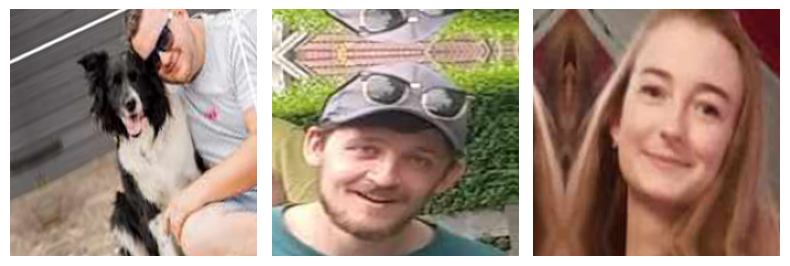

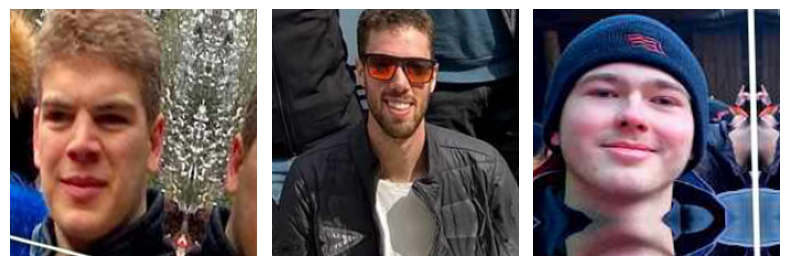

In [90]:
# print some example images
print("Augmented images of the class Dominik and the dataset validation: ")
# Call the function to print the augmented images in the validation dataset for the class "Unknown" 
printImages(images_val_aug_unknown)

In the following, a visual representation is created to illustrate the composition of the three datasets, which include both augmented and original data. The figure provides an overview of the training, validation, and test sets, highlighting the inclusion of augmented images alongside the original ones.

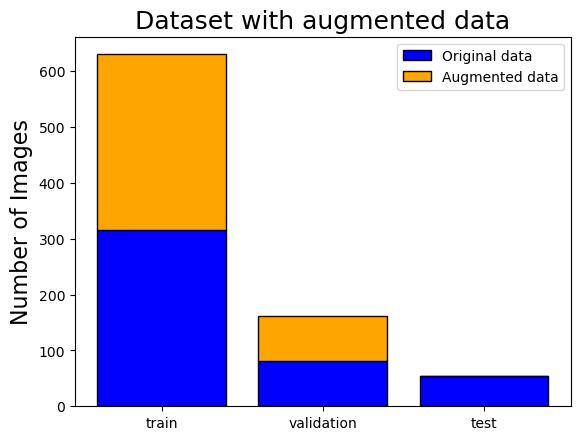

In [22]:
# Define the splits and data origins for the plot
split = ['train', 'validation', 'test']
data_origin = ['Original data', 'Augmented data']

# Create an array of positions based on the number of splits
pos = np.arange(len(split))

# Prepare the values for the 'Original data' bars
values_og = [len(train_dominik_array+train_unknown_array), len(valid_dominik_array+valid_unknown_array), len(X_test_unknown+X_test_dominik)]

# Prepare the values for the 'Augmented data' bars
values_augmented = [len(train_dominik_array+train_unknown_array), len(valid_dominik_array+valid_unknown_array), 0]

# Plotting the bar chart
plt.bar(pos, values_og, color='blue', edgecolor='black')
plt.bar(pos, values_augmented, color='orange', edgecolor='black', bottom=values_og)
plt.xticks(pos, split)
plt.ylabel('Number of Images', fontsize=16)
plt.title('Dataset with augmented data', fontsize=18)
plt.legend(data_origin)
plt.show()


## 6. Models <a id="models"></a>

Now that the images have been pre-processed and moreover the augmented images have been created, the preparation of the data is over. The data can now be used for training as it is in the directory.

Therefore, it is now time to select the models that serve as the basis for transfer learning. For this, the two diagrams from the following figure are considered, these were already discussed in the lecture. It goes without saying that a model should be chosen which has a good top-1 accuracy. However, care should also be taken that the model is not too large. The size of the model is measured by the number of parameters. Using a model that is excessively large for transfer learning can lead to overfitting, as it adapts too closely to the training data and struggles to generalize to new examples. Larger models also require more computational resources, resulting in longer training times and increased memory usage. For this reason, a balance should be found between the accuracy and the size of the model.

As depicted in the figure, several models are available for the intended purpose, including ResNet-50, Inception-v3, ResNet-101, Inception-v4, and ResNet-152. These models exhibit high accuracy while maintaining a relatively compact size compared to VGG16. Consequently, the subsequent sections focus on training, testing, and comparing these models using the provided dataset. However, it's worth noting that the Inception-v4 model is not utilized due to its unavailability in TensorFlow's official implementation. This is attributed to its recent emergence and complex architecture. Therefore, transfer learning will be performed using the three ResNet models (ResNet-50, ResNet-101, and ResNet-152) alongside the Inception-v3 model. In addition to these models, the VGG16 model is also trained. As mentioned before, this serves the purpose of comparing the other models with an already known model.

![modelle.png](Bilder-notebook\modelle.PNG)

Figures copyright Alfredo Canziani, Adam Paszke, Eugenio Culurciello, 2017.

##### **Creating the models:**
Now that the models that will be used for the training have been selected, they must be created. For this, a few parameters are set first. This includes the input format which is the previously mentioned 224x224 pixels. The weights are initilized with the imagenet weights, which means that the pre-trained weights of the model should be initialized on the ImageNet dataset. ImageNet is a large dataset with millions of images and thousands of classes. By using the pre-trained weights from ImageNet, the model can benefit from the already learned features and structures trained on a wide variety of images. 

The dropout rate plays a crucial role in reducing overfitting and enhancing the robustness of the model. By randomly deactivating neurons during training, the model becomes less dependent on specific features and gains resilience against noise. However, it's important to strike a balance. A dropout rate of 0.5 was chosen to prevent excessive dropout while finding a suitable middle ground that mitigates overfitting without compromising the model's capacity. This value ensures a reasonable trade-off between regularization and preserving the model's ability to capture complex patterns in the data.
(Vijay, Upendra. "How Does Dropout Help to Avoid Overfitting in Neural Networks." Medium, Medium, 18 Oct. 2019, https://medium.com/@upendravijay2/how-does-dropout-help-to-avoid-overfitting-in-neural-networks-91b90fd86b20)

The last parameter that is set here is the EarlyStopping. EarlyStopping is a technique used during model training to stop the training process based on a predefined criterion. It monitors a chosen metric, typically on a validation dataset, and stops training if the metric does not improve or worsens consistently over a certain number of epochs. EarlyStopping helps prevent overfitting by ending training early when the model's performance on unseen data is not improving. It optimizes the training process, saves time, and ensures the model is stopped at the point of best validation performance. The metric used here for monitoring is the validation loss, and the patience value is set to 3. This indicates after how many epochs without improvement the training will be stopped. ("EarlyStopping Callback." Keras API Reference, TensorFlow, n.d., https://keras.io/api/callbacks/early_stopping/)


In [23]:
# Define the input shape for the model
input_shape = (224, 224, 3)

# Specify the weights to be used with 'imagenet'
weights = 'imagenet'

dropout_rate = 0.5  # Adjust the dropout rate as desired

# Configure Early Stopping callback
patience = 4  # Number of epochs with no improvement after which training will be stopped
early_stopping = EarlyStopping(monitor='val_loss', patience=patience)


In [66]:
# Create a base model using ResNet50 architecture
ResNet50_base_model = ResNet50(include_top=False, input_shape=input_shape, weights=weights)

# Freeze the layers of the base model
for layer in ResNet50_base_model.layers:
    layer.trainable = False

# Add a classification head on top of the base model
ResNet50_model = tf.keras.Sequential([
    ResNet50_base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    Dropout(dropout_rate),  # Add Dropout layer with the specified rate
    tf.keras.layers.Dense(2, activation='softmax')
])

# create two models for testing two diffrent optimizer (adam and rmsprop)
ResNet50_model_adam = ResNet50_model
ResNet50_model_rmsprop = ResNet50_model

In [67]:
# Create the ResNet101 model
ResNet101_base_model = ResNet101(include_top=False, input_shape=input_shape, weights=weights)

# Freeze the layers of the base model
for layer in ResNet101_base_model.layers:
    layer.trainable = False

# Add a classification head on top of the base model
ResNet101_model = tf.keras.Sequential([
    ResNet101_base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    Dropout(dropout_rate),  # Add Dropout layer with the specified rate
    tf.keras.layers.Dense(2, activation='softmax')
])

# create two models for testing two diffrent optimizer (adam and rmsprop)
ResNet101_model_adam = ResNet101_model
ResNet101_model_rmsprop = ResNet101_model

In [68]:
# Create the ResNet101 model
ResNet152_base_model = ResNet152(include_top=False, input_shape=input_shape, weights=weights)

# Freeze the layers of the base model
for layer in ResNet152_base_model.layers:
    layer.trainable = False

# Add a classification head on top of the base model
ResNet152_model = tf.keras.Sequential([
    ResNet152_base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    Dropout(dropout_rate),  # Add Dropout layer with the specified rate
    tf.keras.layers.Dense(2, activation='softmax')
])

# create two models for testing two diffrent optimizer (adam and rmsprop)
ResNet152_model_adam = ResNet152_model
ResNet152_model_rmsprop = ResNet152_model

In [69]:
# Create the InceptionV3 model
InceptionV3_base_model = InceptionV3(include_top=False, input_shape=input_shape, weights=weights)

# Freeze the layers of the base model
for layer in InceptionV3_base_model.layers:
    layer.trainable = False

# Add a classification head on top of the base model
InceptionV3_model = tf.keras.Sequential([
    InceptionV3_base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    Dropout(dropout_rate),  # Add Dropout layer with the specified rate
    tf.keras.layers.Dense(2, activation='softmax')
])

# create two models for testing two diffrent optimizer (adam and rmsprop)
InceptionV3_model_adam = InceptionV3_model
InceptionV3_model_rmsprop = InceptionV3_model

In [70]:
# Create the VGG16 model
VGG16_base_model = VGG16(include_top=False, input_shape=input_shape, weights=weights)

# Freeze the layers of the base model
for layer in VGG16_base_model.layers:
    layer.trainable = False

# Add a classification head on top of the base model
VGG16_model = tf.keras.Sequential([
    VGG16_base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    Dropout(dropout_rate),  # Add Dropout layer with the specified rate
    tf.keras.layers.Dense(2, activation='softmax')
])

# create two models for testing two diffrent optimizer (adam and rmsprop)
VGG16_model_adam = VGG16_model
VGG16_model_rmsprop = VGG16_model

## 7. Training <a id="training"></a>

In [71]:
# if you want more augmented data you can uncomment the parameters in the ImageDataGenerator
# so there are created more augmented images while trainind
train_datagen = ImageDataGenerator(
    # rotation_range=20,
    # width_shift_range=0.2,
    # height_shift_range=0.2,
    # shear_range=0.2,
    # zoom_range=0.2,
    # horizontal_flip=True
)

validation_datagen = ImageDataGenerator()

In [72]:
# Create data generators for training and validation data

# Define the desired size for input images
IMAGE_SIZE = (224, 224)

# Set the batch size for each iteration during training
batch_size = 16

# Specify the directories containing the training and validation data
train_dir = "data/train/"
val_dir = "data/validation/"

# Create a data generator for training data
train_generator = train_datagen.flow_from_directory(
    train_dir,                            # Directory containing the training data
    batch_size=batch_size,                # Number of samples per batch
    target_size=IMAGE_SIZE,               # Resize input images to the specified size
    shuffle=True,                         # Shuffle the order of images during training
    class_mode='categorical'              # Generate one-hot encoded labels for multi-class classification
)

# Create a data generator for validation data
validation_generator = validation_datagen.flow_from_directory(
    val_dir,                              # Directory containing the validation data
    batch_size=batch_size,                # Number of samples per batch
    target_size=IMAGE_SIZE,               # Resize input images to the specified size
    shuffle=True,                         # Shuffle the order of images during validation
    class_mode='categorical'              # Generate one-hot encoded labels for multi-class classification
)

Found 630 images belonging to 2 classes.
Found 188 images belonging to 2 classes.


In [73]:
# Compile the models

# Set the optimizer, loss function, and metrics for evaluation
optimizer_rms = 'rmsprop'    # Options: 'adam', 'rmsprop'
optimizer_adam = 'adam'
loss = 'categorical_crossentropy'
metrics = ['accuracy']

# Compile each model with the rmsprop optimizer, loss, and metrics
VGG16_model_adam.compile(optimizer=optimizer_adam, loss=loss, metrics=metrics)
ResNet50_model_adam.compile(optimizer=optimizer_adam, loss=loss, metrics=metrics)
ResNet101_model_adam.compile(optimizer=optimizer_adam, loss=loss, metrics=metrics)
ResNet152_model_adam.compile(optimizer=optimizer_adam, loss=loss, metrics=metrics)
InceptionV3_model_adam.compile(optimizer=optimizer_adam, loss=loss, metrics=metrics)

VGG16_model_rmsprop.compile(optimizer=optimizer_rms, loss=loss, metrics=metrics)
ResNet50_model_rmsprop.compile(optimizer=optimizer_rms, loss=loss, metrics=metrics)
ResNet101_model_rmsprop.compile(optimizer=optimizer_rms, loss=loss, metrics=metrics)
ResNet152_model_rmsprop.compile(optimizer=optimizer_rms, loss=loss, metrics=metrics)
InceptionV3_model_rmsprop.compile(optimizer=optimizer_rms, loss=loss, metrics=metrics)

In [74]:
# Train the models

# Calculate the total number of validation images
total_val = 2 * len(valid_dominik_array + valid_unknown_array)

# Set the number of epochs for training
epochs = 15

# Calculate the steps per epoch and validation steps
steps_per_epoch = total_val // batch_size
validation_steps = total_val // batch_size

# Train each model and store the training history
print("#########################################################################")
# VGG16 model
print('VGG16 (optimizer: adam):')
history_VGG16 = VGG16_model_adam.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=epochs, validation_data=validation_generator, validation_steps=validation_steps, callbacks=[early_stopping])
print('VGG16 (optimizer: rmsprop):')
history_VGG16 = VGG16_model_rmsprop.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=epochs, validation_data=validation_generator, validation_steps=validation_steps, callbacks=[early_stopping])

print("#########################################################################")

# ResNet50 model
print('ResNet50 (optimizer: adam):')
history_ResNet50 = ResNet50_model_adam.fit(train_generator, epochs=epochs, steps_per_epoch=steps_per_epoch, validation_data=validation_generator, validation_steps=validation_steps, callbacks=[early_stopping])
print('ResNet50 (optimizer: rmsprop):')
history_ResNet50 = ResNet50_model_rmsprop.fit(train_generator, epochs=epochs, steps_per_epoch=steps_per_epoch, validation_data=validation_generator, validation_steps=validation_steps, callbacks=[early_stopping])

print("#########################################################################")

# ResNet101 model
print('ResNet101 (optimizer: adam):')
history_ResNet101 = ResNet101_model_adam.fit(train_generator, epochs=epochs, steps_per_epoch=steps_per_epoch, validation_data=validation_generator, validation_steps=validation_steps, callbacks=[early_stopping])
print('ResNet101 (optimizer: rmsprop):')
history_ResNet101 = ResNet101_model_rmsprop.fit(train_generator, epochs=epochs, steps_per_epoch=steps_per_epoch, validation_data=validation_generator, validation_steps=validation_steps, callbacks=[early_stopping])

print("#########################################################################")

# EfficientNetB0 model
print('ResNet152 (optimizer: adam):')
history_ResNet152 = ResNet152_model_adam.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=epochs, validation_data=validation_generator, validation_steps=validation_steps, callbacks=[early_stopping])
print('ResNet101 (optimizer: rmsprop):')
history_ResNet152 = ResNet152_model_rmsprop.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=epochs, validation_data=validation_generator, validation_steps=validation_steps, callbacks=[early_stopping])

print("#########################################################################")

# InceptionV3 model
print('InceptionV3 (optimizer: adam):')
history_InceptionV3 = InceptionV3_model_adam.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=epochs, validation_data=validation_generator, validation_steps=validation_steps, callbacks=[early_stopping])
print('InceptionV3 (optimizer: rmsprop):')
history_InceptionV3 = InceptionV3_model_rmsprop.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=epochs, validation_data=validation_generator, validation_steps=validation_steps, callbacks=[early_stopping])


#########################################################################
VGG16 (optimizer: adam):
Epoch 1/15
10/10 [==============================] - 17s 2s/step - loss: 3.4848 - accuracy: 0.5125 - val_loss: 1.4099 - val_accuracy: 0.6812
Epoch 2/15
10/10 [==============================] - 17s 2s/step - loss: 2.2265 - accuracy: 0.6500 - val_loss: 0.9549 - val_accuracy: 0.7812
Epoch 3/15
10/10 [==============================] - 17s 2s/step - loss: 1.6700 - accuracy: 0.6687 - val_loss: 0.9147 - val_accuracy: 0.8500
Epoch 4/15
10/10 [==============================] - 17s 2s/step - loss: 1.6833 - accuracy: 0.7375 - val_loss: 0.5421 - val_accuracy: 0.8875
Epoch 5/15
10/10 [==============================] - 16s 2s/step - loss: 1.2307 - accuracy: 0.7800 - val_loss: 0.3355 - val_accuracy: 0.9062
Epoch 6/15
10/10 [==============================] - 16s 2s/step - loss: 1.1965 - accuracy: 0.8000 - val_loss: 0.2161 - val_accuracy: 0.9375
Epoch 7/15
10/10 [==============================] - 16s 2s/st

In [56]:
# Save the weights of the trained models
VGG16_model.save_weights('models/VGG16_model_weights.h5')
ResNet50_model.save_weights('models/ResNet50_model_weights.h5')
ResNet101_model.save_weights('models/ResNet101_model_weights.h5')
ResNet152_model.save_weights('models/ResNet152_model_weights.h5')
InceptionV3_model.save_weights('models/InceptionV3_model_weights.h5')

# Save the entire trained models
VGG16_model.save('models/VGG16_model.h5')
ResNet50_model.save('models/ResNet50_model.h5')
ResNet101_model.save('models/ResNet101_model.h5')
ResNet152_model.save('models/ResNet152_model.h5')
InceptionV3_model.save('models/InceptionV3_model.h5')

## 8. Evaluation <a id="eva"></a>

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


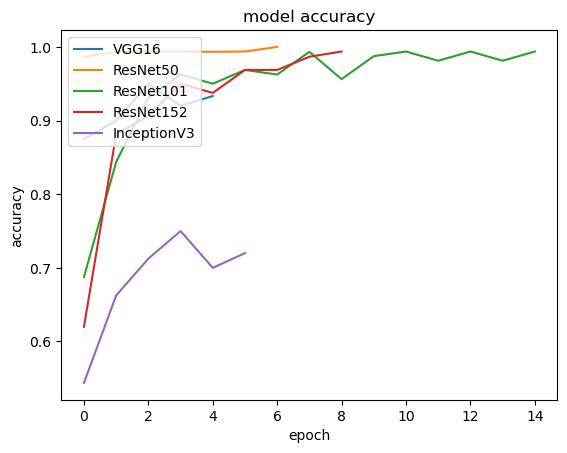

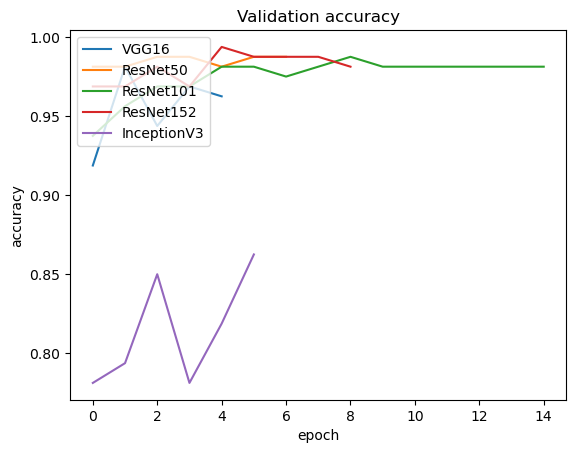

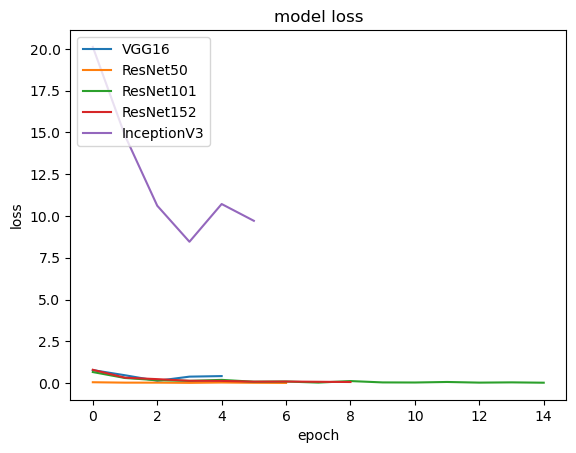

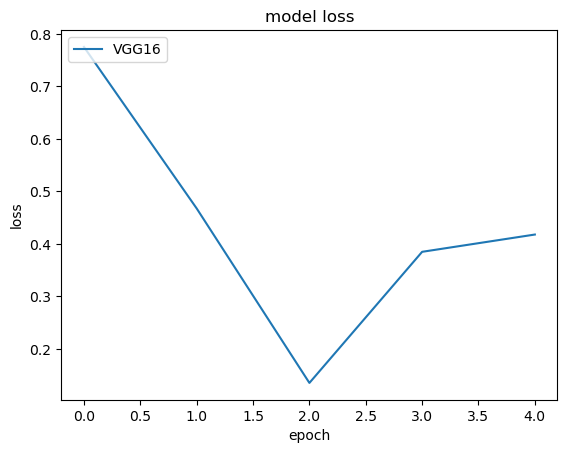

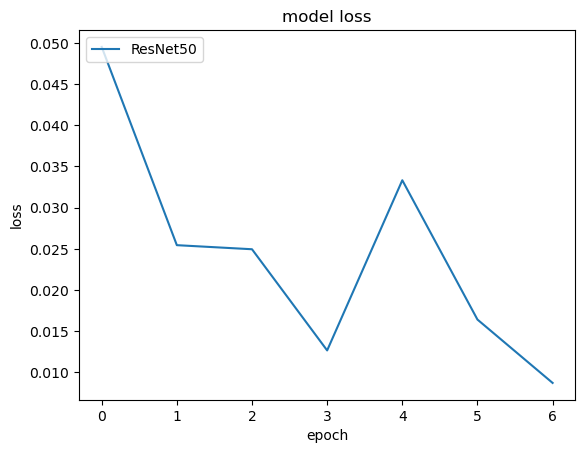

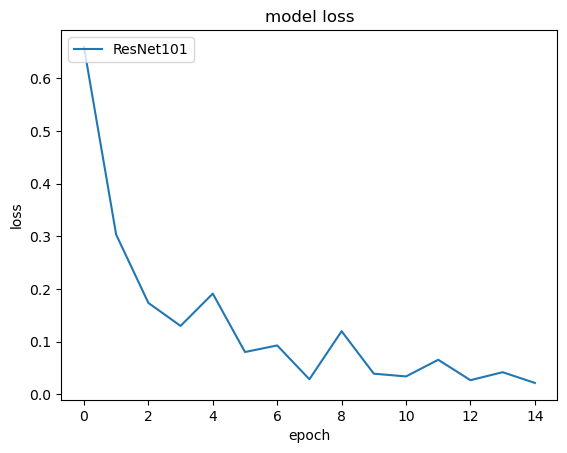

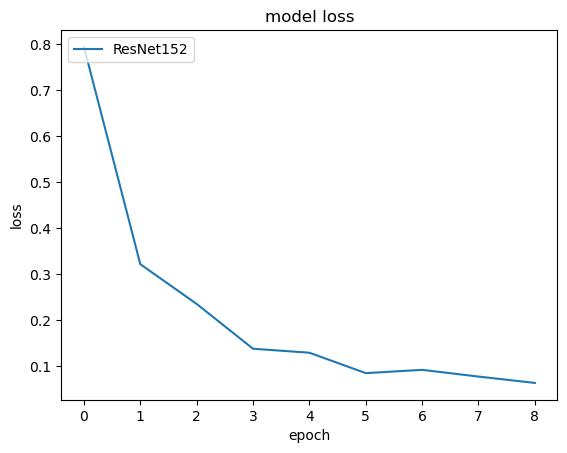

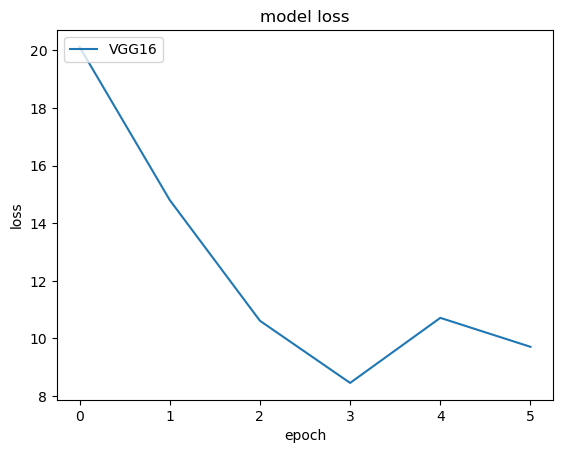

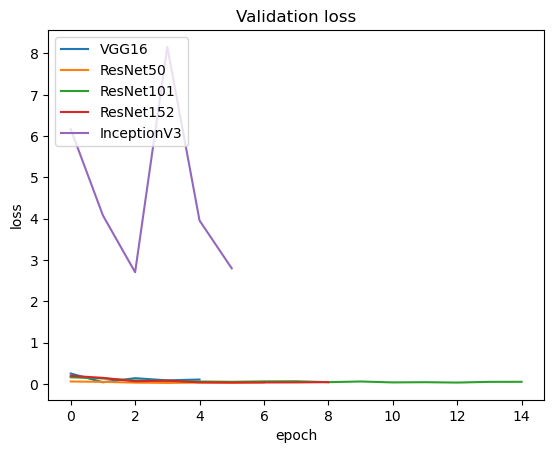

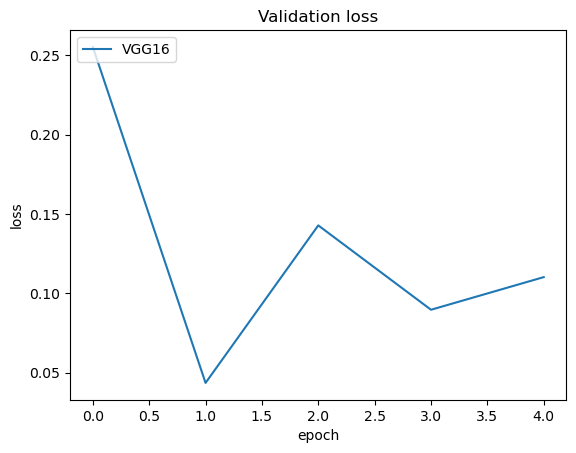

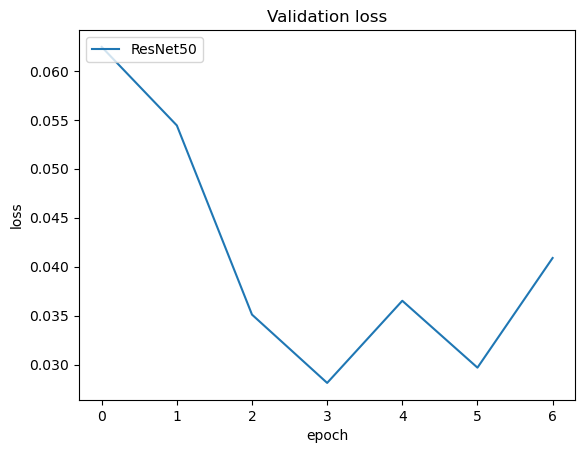

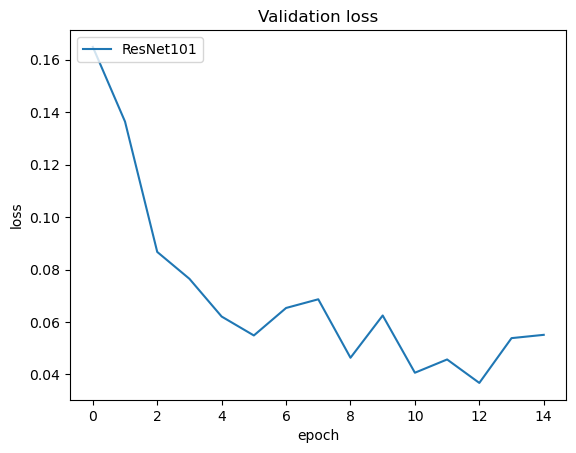

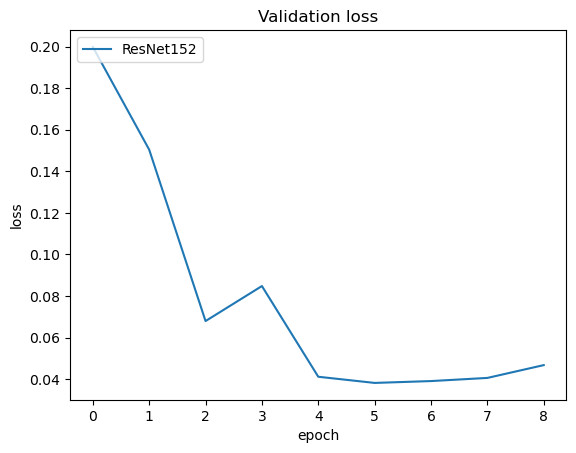

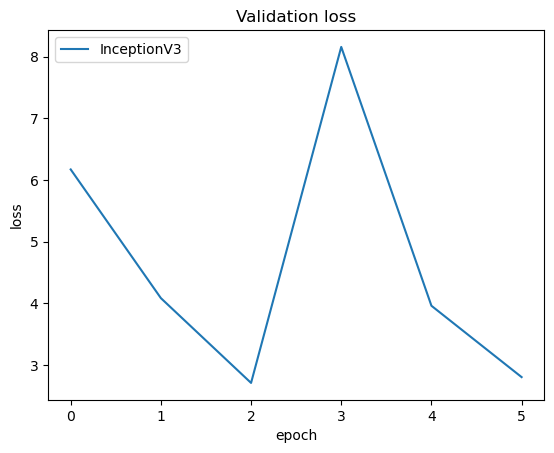

In [57]:
# Plot training & validation accuracy values of VGG16
print(history_VGG16.history.keys())
#  "Accuracy"
plt.plot(history_VGG16.history['accuracy'], label = "VGG16")
plt.plot(history_ResNet50.history['accuracy'], label = "ResNet50")
plt.plot(history_ResNet101.history['accuracy'], label = "ResNet101")
plt.plot(history_ResNet152.history['accuracy'], label = "ResNet152")
plt.plot(history_InceptionV3.history['accuracy'], label = "InceptionV3")
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['VGG16', 'ResNet50', 'ResNet101', 'ResNet152', 'InceptionV3'], loc='upper left')
plt.show()

#  "val_accuracy"
plt.plot(history_VGG16.history['val_accuracy'], label = "VGG16")
plt.plot(history_ResNet50.history['val_accuracy'], label = "ResNet50")
plt.plot(history_ResNet101.history['val_accuracy'], label = "ResNet101")
plt.plot(history_ResNet152.history['val_accuracy'], label = "ResNet152")
plt.plot(history_InceptionV3.history['val_accuracy'], label = "InceptionV3")
plt.title('Validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['VGG16', 'ResNet50', 'ResNet101', 'ResNet152', 'InceptionV3'], loc='upper left')
plt.show()


# "Loss"
plt.plot(history_VGG16.history['loss'], label = "VGG16")
plt.plot(history_ResNet50.history['loss'], label = "ResNet50")
plt.plot(history_ResNet101.history['loss'], label = "ResNet101")
plt.plot(history_ResNet152.history['loss'], label = "ResNet152")
plt.plot(history_InceptionV3.history['loss'], label = "InceptionV3")
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['VGG16', 'ResNet50', 'ResNet101', 'ResNet152', 'InceptionV3'], loc='upper left')
plt.show()

plt.plot(history_VGG16.history['loss'], label = "VGG16")
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['VGG16'], loc='upper left')
plt.show()


plt.plot(history_ResNet50.history['loss'], label = "ResNet50")
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['ResNet50'], loc='upper left')
plt.show()


plt.plot(history_ResNet101.history['loss'], label = "ResNet101")
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['ResNet101'], loc='upper left')
plt.show()


plt.plot(history_ResNet152.history['loss'], label = "ResNet152")
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['ResNet152'], loc='upper left')
plt.show()


plt.plot(history_InceptionV3.history['loss'], label = "InceptionV3")
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['VGG16', 'ResNet50', 'ResNet101', 'ResNet152', 'InceptionV3'], loc='upper left')
plt.show()




# "val_loss"
plt.plot(history_VGG16.history['val_loss'], label = "VGG16")
plt.plot(history_ResNet50.history['val_loss'], label = "ResNet50")
plt.plot(history_ResNet101.history['val_loss'], label = "ResNet101")
plt.plot(history_ResNet152.history['val_loss'], label = "ResNet152")
plt.plot(history_InceptionV3.history['val_loss'], label = "InceptionV3")
plt.title('Validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['VGG16', 'ResNet50', 'ResNet101', 'ResNet152', 'InceptionV3'], loc='upper left')
plt.show()

plt.plot(history_VGG16.history['val_loss'], label = "VGG16")
plt.title('Validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['VGG16'], loc='upper left')
plt.show()

plt.plot(history_ResNet50.history['val_loss'], label = "ResNet50")
plt.title('Validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['ResNet50'], loc='upper left')
plt.show()


plt.plot(history_ResNet101.history['val_loss'], label = "ResNet101")
plt.title('Validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['ResNet101'], loc='upper left')
plt.show()


plt.plot(history_ResNet152.history['val_loss'], label = "ResNet152")
plt.title('Validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['ResNet152'], loc='upper left')
plt.show()


plt.plot(history_InceptionV3.history['val_loss'], label = "InceptionV3")
plt.title('Validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['InceptionV3'], loc='upper left')
plt.show()

## 9. Testing <a id="testing"></a>

In [58]:
images_dominik_norm = []
for i in range(len(images_dominik)):
        temp_data = img_to_array(images_dominik[i])
        img_norm = cv2.normalize(temp_data, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
        images_dominik_norm.append(array_to_img(img_norm))

In [119]:
import numpy as np
from PIL import Image
from keras.models import load_model


# Load the .h5 models
model_path_VGG16 = 'models/VGG16_model.h5'
model_path_ResNet50 = 'models/ResNet50_model.h5'
model_path_ResNet101 = 'models/ResNet101_model.h5'
model_path_ResNet152 = 'models/ResNet152_model.h5'
model_path_InceptionV3 = 'models/InceptionV3_model.h5'

VGG16_model = load_model(model_path_VGG16)
ResNet50_model = load_model(model_path_ResNet50)
ResNet101_model = load_model(model_path_ResNet101)
ResNet152_model = load_model(model_path_ResNet152)
InceptionV3_model = load_model(model_path_InceptionV3)

# Load and prepare the test images
test_path_dominik = 'data/test/Dominik'
test_path_unknown = 'data/test/unknown'

def getImages(test_image_folder):
    test_images = []
    for image_path in os.listdir(test_image_folder):
        image = Image.open(os.path.join(test_image_folder, image_path))
        temp_data = img_to_array(image)
        img_norm = cv2.normalize(temp_data, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
        image_norm = array_to_img(img_norm)

        image = image_norm.resize((224, 224))  # Adjust the image size according to your requirements
        image = np.array(image)# / 255.0  # Normalize the image pixels to the range 0-1
        test_images.append(image)

    # Convert the list of images to a Numpy array
    test_images = np.array(test_images)
    return test_images

test_images_dominik = getImages(test_path_dominik)
test_images_unknown = getImages(test_path_unknown)

# Apply the models to the test dataset
predictions_dominik_VGG16_model = VGG16_model.predict(test_images_dominik)
predictions_unknown_VGG16_model = VGG16_model.predict(test_images_unknown)

predictions_dominik_ResNet50_model = ResNet50_model.predict(test_images_dominik)
predictions_unknown_ResNet50_model = ResNet50_model.predict(test_images_unknown)

predictions_dominik_ResNet101_model = ResNet101_model.predict(test_images_dominik)
predictions_unknown_ResNet101_model = ResNet101_model.predict(test_images_unknown)

predictions_dominik_ResNet152_model = ResNet152_model.predict(test_images_dominik)
predictions_unknown_ResNet152_model = ResNet152_model.predict(test_images_unknown)

predictions_dominik_InceptionV3_model = InceptionV3_model.predict(test_images_dominik)
predictions_unknown_InceptionV3_model = InceptionV3_model.predict(test_images_unknown)


In [141]:
import numpy as np

test_labels_dominik = np.array(['Dominik'] * len(test_images_dominik))
test_labels_unknown = np.array(['Unknown'] * len(test_images_unknown))


all_test_labels = np.concatenate((test_labels_dominik, test_labels_unknown))
all_test_images = np.concatenate((test_images_dominik, test_images_unknown))

print(all_test_labels)

# Get the indices for shuffling
indices = np.arange(len(all_test_labels))

# Shuffle the indices
np.random.shuffle(indices)

# Shuffle the arrays using the shuffled indices
shuffled_labels = all_test_labels[indices]
shuffled_images = all_test_images[indices]

print(shuffled_labels)
print(shuffled_images)


['Dominik' 'Dominik' 'Dominik' 'Dominik' 'Dominik' 'Dominik' 'Dominik'
 'Dominik' 'Dominik' 'Dominik' 'Dominik' 'Dominik' 'Dominik' 'Dominik'
 'Dominik' 'Dominik' 'Dominik' 'Dominik' 'Dominik' 'Dominik' 'Dominik'
 'Dominik' 'Dominik' 'Dominik' 'Dominik' 'Dominik' 'Dominik' 'Dominik'
 'Dominik' 'Dominik' 'Dominik' 'Dominik' 'Dominik' 'Dominik' 'Dominik'
 'Dominik' 'Unknown' 'Unknown' 'Unknown' 'Unknown' 'Unknown' 'Unknown'
 'Unknown' 'Unknown' 'Unknown' 'Unknown' 'Unknown' 'Unknown' 'Unknown'
 'Unknown' 'Unknown' 'Unknown' 'Unknown' 'Unknown']
['Dominik' 'Dominik' 'Unknown' 'Unknown' 'Unknown' 'Dominik' 'Unknown'
 'Dominik' 'Dominik' 'Unknown' 'Dominik' 'Dominik' 'Dominik' 'Unknown'
 'Dominik' 'Unknown' 'Dominik' 'Dominik' 'Dominik' 'Dominik' 'Dominik'
 'Unknown' 'Dominik' 'Unknown' 'Dominik' 'Dominik' 'Dominik' 'Unknown'
 'Dominik' 'Dominik' 'Unknown' 'Unknown' 'Unknown' 'Dominik' 'Unknown'
 'Dominik' 'Dominik' 'Unknown' 'Dominik' 'Dominik' 'Unknown' 'Dominik'
 'Dominik' 'Dominik' 'Dom

In [143]:

from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

# Convert labels to numerical values
label_encoder = LabelEncoder()
numerical_labels_dom = label_encoder.fit_transform(shuffled_labels)

print(numerical_labels_dom)

# Convert numerical labels to one-hot encoded format
one_hot_labels_dom = to_categorical(numerical_labels_dom, num_classes=2)


# Evaluate the model on the test dataset
ResNet50_adam_test_loss, ResNet50_adam_test_accuracy = ResNet50_model_adam.evaluate(shuffled_images, one_hot_labels_dom)
ResNet101_adam_test_loss, ResNet101_adam_test_accuracy = ResNet101_model_adam.evaluate(shuffled_images, one_hot_labels_dom)
ResNet152_adam_test_loss, ResNet152_adam_test_accuracy = ResNet152_model_adam.evaluate(shuffled_images, one_hot_labels_dom)
InceptionV3_adam_test_loss, InceptionV3_adam_test_accuracy = InceptionV3_model_adam.evaluate(shuffled_images, one_hot_labels_dom)
VGG16_adam_model_test_loss, VGG16_model_adam_test_accuracy = VGG16_model_adam.evaluate(shuffled_images, one_hot_labels_dom)

ResNet50_rmsprop_test_loss, ResNet50_rmsprop_rmsprop_test_accuracy = ResNet50_model_rmsprop.evaluate(shuffled_images, one_hot_labels_dom)
ResNet101_rmsprop_test_loss, ResNet101_rmsprop_test_accuracy = ResNet101_model_rmsprop.evaluate(shuffled_images, one_hot_labels_dom)
ResNet152_rmsprop_test_loss, ResNet152_rmsprop_test_accuracy = ResNet152_model_rmsprop.evaluate(shuffled_images, one_hot_labels_dom)
InceptionV3_rmsprop_test_loss, InceptionV3_rmsprop_test_accuracy = InceptionV3_model_rmsprop.evaluate(shuffled_images, one_hot_labels_dom)
VGG16_model_rmsprop_test_loss, VGG16_rmsprop_model_test_accuracy = VGG16_model_rmsprop.evaluate(shuffled_images, one_hot_labels_dom)


print('Test Loss:', ResNet50_adam_test_loss)
print('Test Accuracy:', ResNet50_adam_test_accuracy)



[0 0 1 1 1 0 1 0 0 1 0 0 0 1 0 1 0 0 0 0 0 1 0 1 0 0 0 1 0 0 1 1 1 0 1 0 0
 1 0 0 1 0 0 0 0 0 0 0 0 0 0 1 1 0]
2/2 [==============================] - 1s 565ms/step - loss: 0.1704 - accuracy: 0.9630
Test Loss: 0.11952341347932816
Test Accuracy: 0.9629629850387573


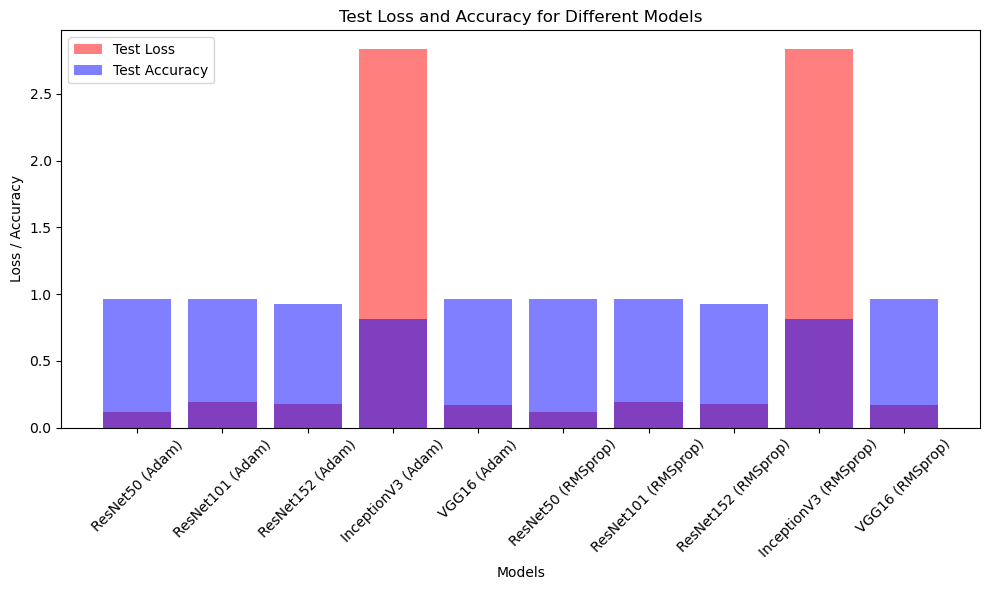

In [144]:
import matplotlib.pyplot as plt

# Test losses
test_losses = [
    ResNet50_adam_test_loss, ResNet101_adam_test_loss, ResNet152_adam_test_loss,
    InceptionV3_adam_test_loss, VGG16_adam_model_test_loss,
    ResNet50_rmsprop_test_loss, ResNet101_rmsprop_test_loss, ResNet152_rmsprop_test_loss,
    InceptionV3_rmsprop_test_loss, VGG16_model_rmsprop_test_loss
]

# Test accuracies
test_accuracies = [
    ResNet50_adam_test_accuracy, ResNet101_adam_test_accuracy, ResNet152_adam_test_accuracy,
    InceptionV3_adam_test_accuracy, VGG16_model_adam_test_accuracy,
    ResNet50_rmsprop_rmsprop_test_accuracy, ResNet101_rmsprop_test_accuracy, ResNet152_rmsprop_test_accuracy,
    InceptionV3_rmsprop_test_accuracy, VGG16_rmsprop_model_test_accuracy
]

# Model names
model_names = [
    'ResNet50 (Adam)', 'ResNet101 (Adam)', 'ResNet152 (Adam)', 'InceptionV3 (Adam)', 'VGG16 (Adam)',
    'ResNet50 (RMSprop)', 'ResNet101 (RMSprop)', 'ResNet152 (RMSprop)', 'InceptionV3 (RMSprop)', 'VGG16 (RMSprop)'
]

# Create the plot
plt.figure(figsize=(10, 6))
plt.bar(model_names, test_losses, color='red', alpha=0.5, label='Test Loss')
plt.bar(model_names, test_accuracies, color='blue', alpha=0.5, label='Test Accuracy')

# Customize the plot
plt.title('Test Loss and Accuracy for Different Models')
plt.xlabel('Models')
plt.ylabel('Loss / Accuracy')
plt.xticks(rotation=45)
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()


In [103]:
def getLabel_from_prediction(predicitons):
    labels = []
    for i in range(len(predicitons)):
        if predicitons[i][0] > predicitons[i][1]:
            labels.append("Dominik")
        else:
            labels.append("Unknown")
    return labels


labels_dominik_VGG16_model = getLabel_from_prediction(predictions_dominik_VGG16_model)
labels_unknown_VGG16_model = getLabel_from_prediction(predictions_unknown_VGG16_model)

labels_dominik_ResNet50_model = getLabel_from_prediction(predictions_dominik_ResNet50_model)
labels_unknown_ResNet50_model = getLabel_from_prediction(predictions_unknown_ResNet50_model)

labels_dominik_ResNet101_model = getLabel_from_prediction(predictions_dominik_ResNet101_model)
labels_unknown_ResNet101_model = getLabel_from_prediction(predictions_unknown_ResNet101_model)

labels_dominik_ResNet152_model = getLabel_from_prediction(predictions_dominik_ResNet152_model)
labels_unknown_ResNet152_model = getLabel_from_prediction(predictions_unknown_ResNet152_model)

labels_dominik_InceptionV3_model = getLabel_from_prediction(predictions_dominik_InceptionV3_model)
labels_unknown_InceptionV3_model = getLabel_from_prediction(predictions_unknown_InceptionV3_model)

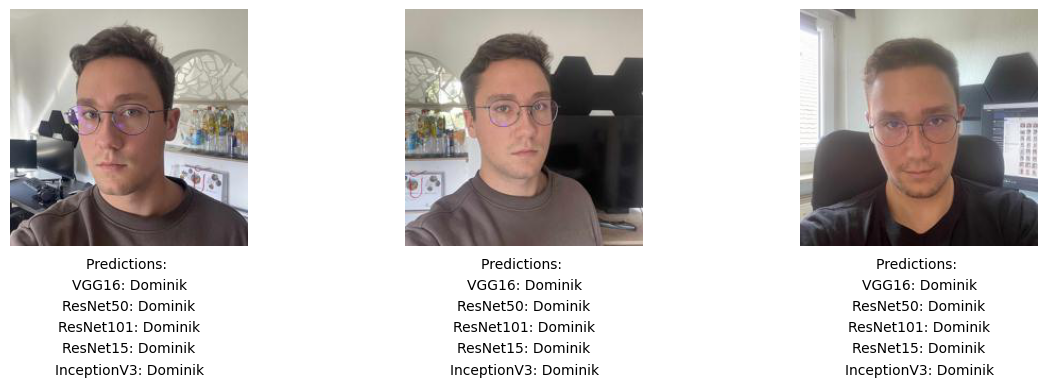

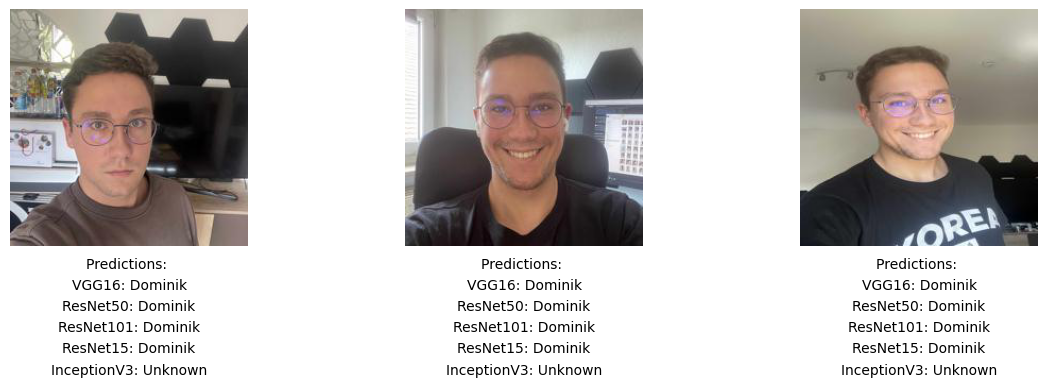

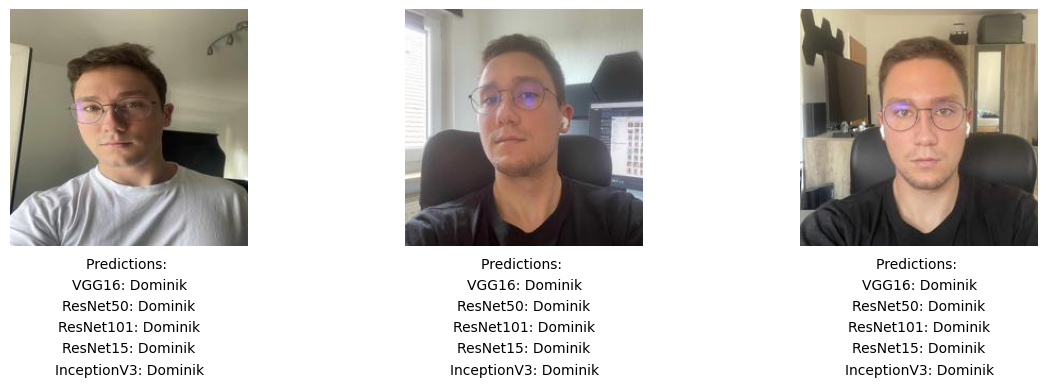

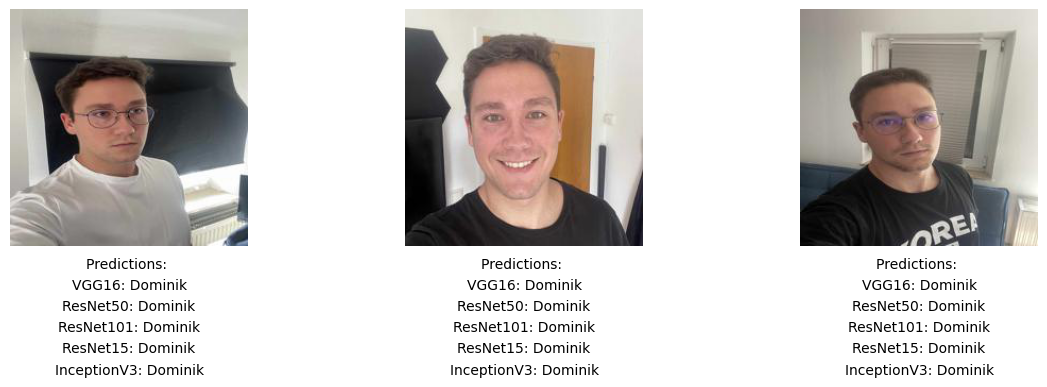

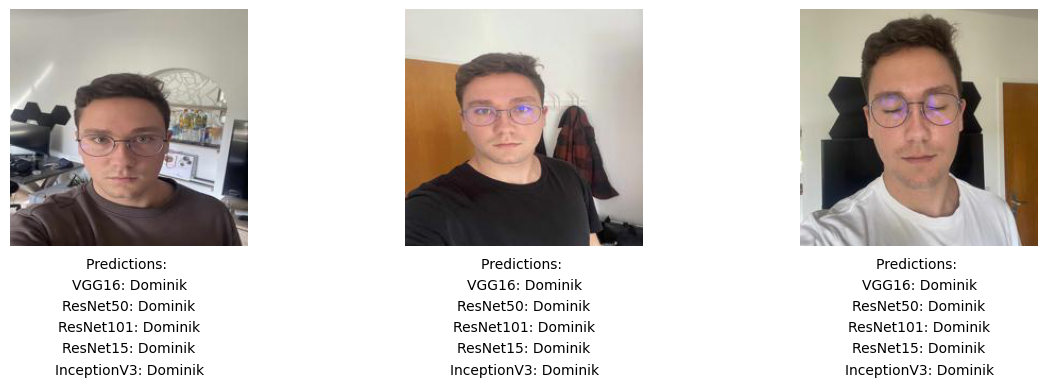

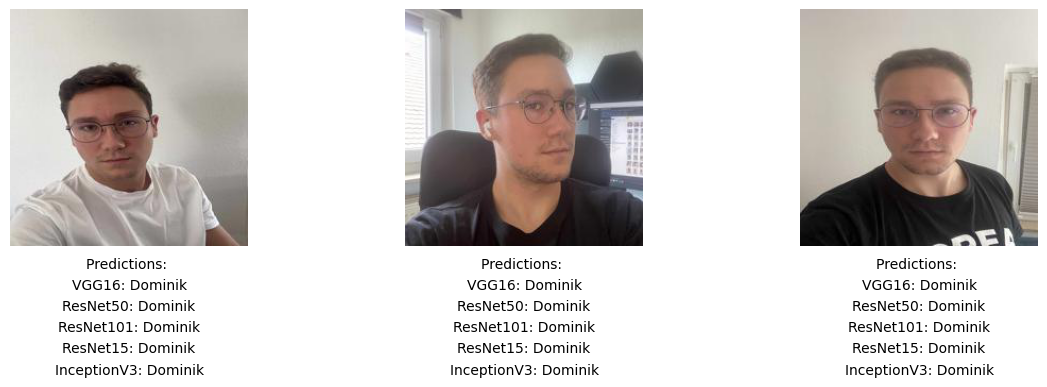

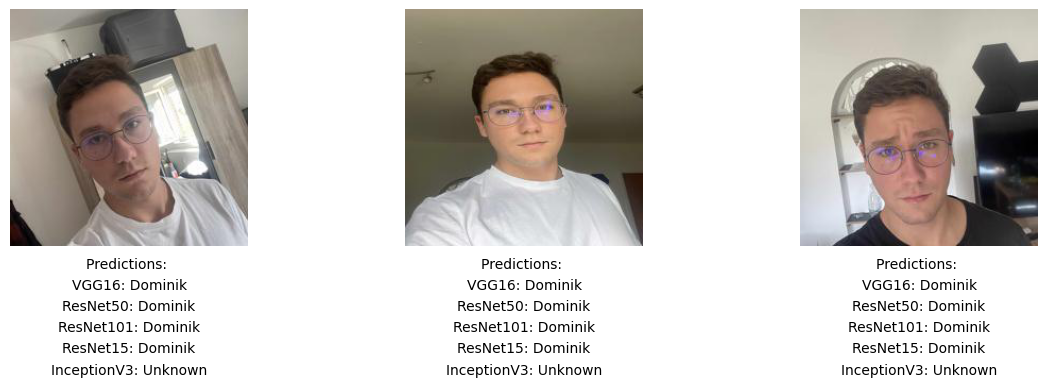

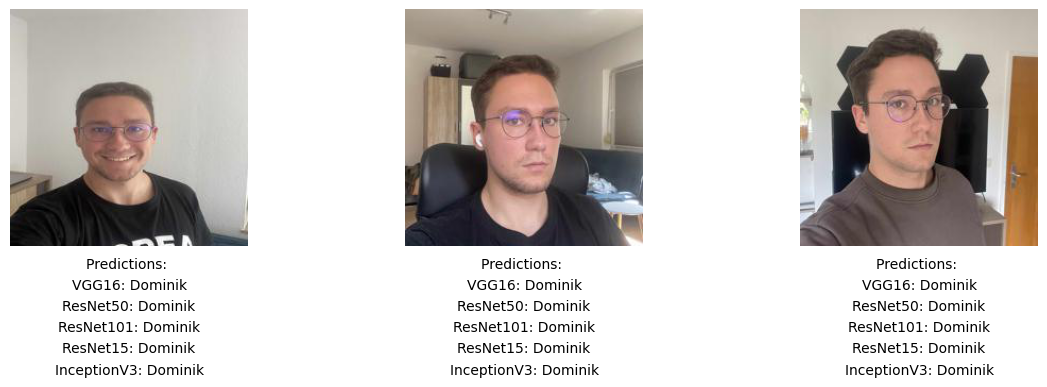

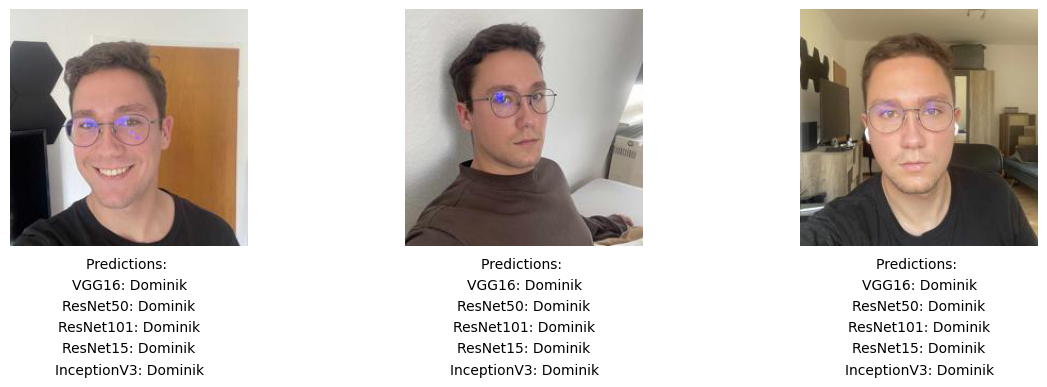

In [62]:
images_dominik = []
for i in range(len(test_images_dominik)):
    image = array_to_img(test_images_dominik[i])
    images_dominik.append(image)


for i in range(0, 27,3):
    # Create a figure and axes
    fig, ax = plt.subplots(1,3, figsize=(12, 4))

    # Display the image
    ax[0].imshow(images_dominik[i])
    ax[1].imshow(images_dominik[i+1])
    ax[2].imshow(images_dominik[i+2])

    # Add a legend
    legend_text = ""
    ax[0].text(10, 10, legend_text, color='white', backgroundcolor='black')
    ax[1].text(10, 10, legend_text, color='white', backgroundcolor='black')
    ax[2].text(10, 10, legend_text, color='white', backgroundcolor='black')
    # ax[2].text(10, 10, legend_text, color='white', backgroundcolor='black')
    
    # predictions
    text_vgg16 = "VGG16: " + labels_dominik_VGG16_model[i]
    text_ResNet50 = "ResNet50: " + labels_dominik_ResNet50_model[i]
    text_ResNet101 = "ResNet101: " + labels_dominik_ResNet101_model[i]
    text_ResNet15 = "ResNet15: " + labels_dominik_ResNet152_model[i]
    text_InceptionV3 = "InceptionV3: " + labels_dominik_InceptionV3_model[i]

    # Add text under the image
    text_lines = ["Predictions: ", text_vgg16, text_ResNet50, text_ResNet101, text_ResNet15, text_InceptionV3]
    text_position = (image.width // 2, image.height + 20)
    for line in text_lines:
        ax[0].text(*text_position, line, color='black', ha='center')
        ax[1].text(*text_position, line, color='black', ha='center')
        ax[2].text(*text_position, line, color='black', ha='center')
        text_position = (text_position[0], text_position[1] + 20)
        
    
    # Remove the axis labels
    ax[0].axis("off")
    ax[1].axis("off")
    ax[2].axis("off")
    
    # Adjust the layout
    plt.tight_layout()

    # Show the plot
    plt.show()

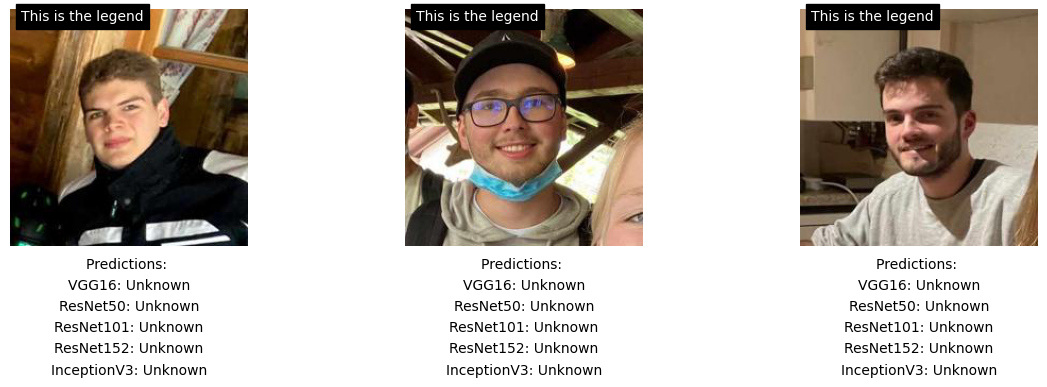

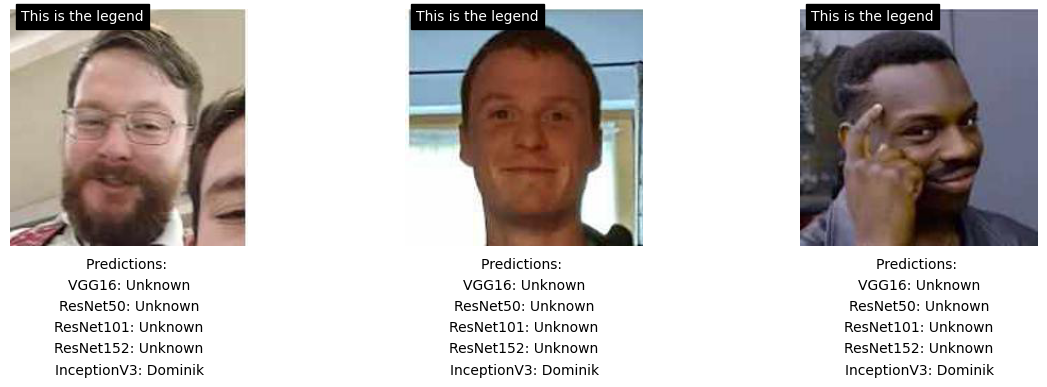

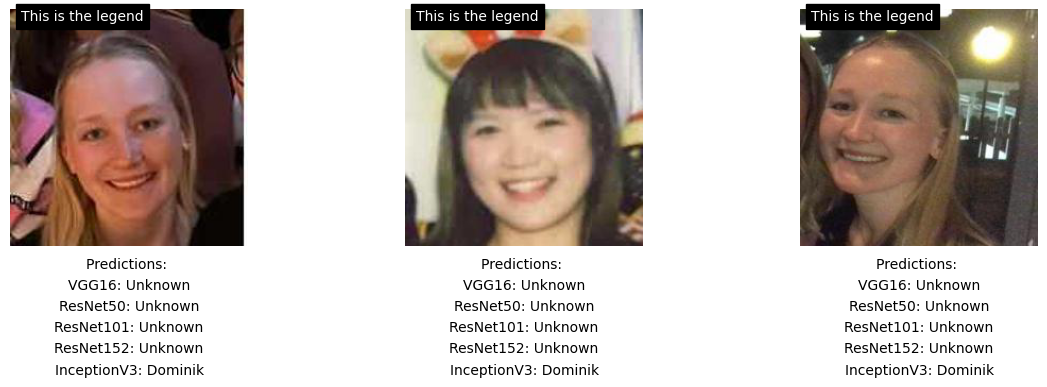

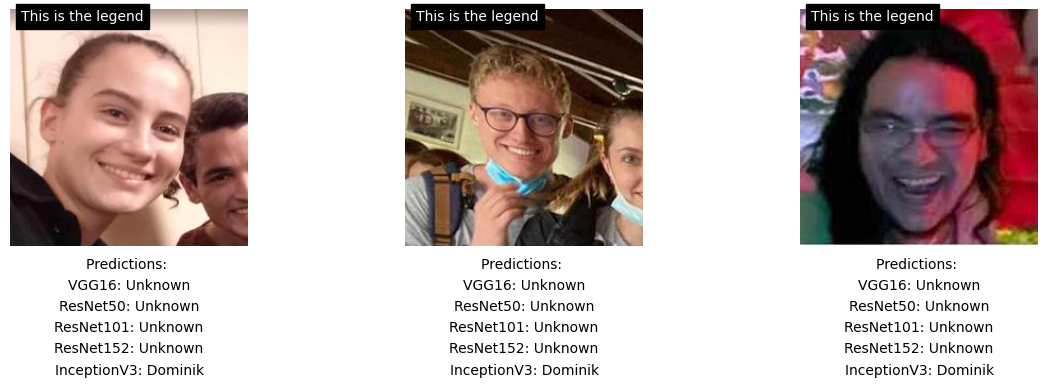

In [63]:
images_unknown = []
for i in range(len(test_images_unknown)):
    image = array_to_img(test_images_unknown[i])
    images_unknown.append(image)


for i in range(0, 12,3):
    # Create a figure and axes
    fig, ax = plt.subplots(1,3, figsize=(12, 4))

    # Display the image
    ax[0].imshow(images_unknown[i])
    ax[1].imshow(images_unknown[i+1])
    ax[2].imshow(images_unknown[i+2])

    # Add a legend
    legend_text = "This is the legend"
    ax[0].text(10, 10, legend_text, color='white', backgroundcolor='black')
    ax[1].text(10, 10, legend_text, color='white', backgroundcolor='black')
    ax[2].text(10, 10, legend_text, color='white', backgroundcolor='black')

    # predictions
    text_vgg16 = "VGG16: " + labels_unknown_VGG16_model[i]
    text_ResNet50 = "ResNet50: " + labels_unknown_ResNet50_model[i]
    text_ResNet101 = "ResNet101: " + labels_unknown_ResNet101_model[i]
    text_ResNet152 = "ResNet152: " + labels_unknown_ResNet152_model[i]
    text_InceptionV3 = "InceptionV3: " + labels_unknown_InceptionV3_model[i]

    # Add text under the image
    text_lines = ["Predictions: ", text_vgg16, text_ResNet50, text_ResNet101, text_ResNet152, text_InceptionV3]
    text_position = (image.width // 2, image.height + 20)
    for line in text_lines:
        ax[0].text(*text_position, line, color='black', ha='center')
        ax[1].text(*text_position, line, color='black', ha='center')
        ax[2].text(*text_position, line, color='black', ha='center')
        text_position = (text_position[0], text_position[1] + 20)
        
    
    # Remove the axis labels
    ax[0].axis("off")
    ax[1].axis("off")
    ax[2].axis("off")
    
    # Adjust the layout
    plt.tight_layout()

    # Show the plot
    plt.show()

## 10. Live face recognition <a id="live"></a>

In [9]:
# Paths to the face recognition model and cascade files

# Load the .h5 models
model_path_VGG16 = 'models/VGG16_model.h5'
model_path_ResNet50 = 'ResNet50_model.h5'
model_path_ResNet101 = 'models/ResNet101_model.h5'
model_path_EfficientNetB0 = 'models/EfficientNetB0_model.h5'
model_path_InceptionV3 = 'models/InceptionV3_model.h5'


# Select one of the five pre-trained models, while keeping the remaining models commented out!
##############################################################################################
# model = load_model(model_path_VGG16)
model = load_model(model_path_ResNet50)
# model = load_model(model_path_ResNet101)
# model = load_model(model_path_EfficientNetB0)
# model = load_model(model_path_InceptionV3)
##############################################################################################

# Paths to the cascade file
face_cascade_path = cv2.data.haarcascades + 'haarcascade_frontalface_default.xml'
# Create cascade classifier for face detection
face_cascade = cv2.CascadeClassifier(face_cascade_path)

classes = { 0:'Dominik',  
            1:'Unknown'}

# Function to detect faces
def detect_faces(image):
    rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(rgb, scaleFactor=1.2, minNeighbors=5, minSize=(30, 30))
    return faces

# Initialize webcam
cap = cv2.VideoCapture(0)


# Check if the webcam is available
if not cap.isOpened():
    print("No webcam found or access denied.")
else:
    # Infinite loop for face recognition
    while True:
        # Capture frame from the webcam
        ret, frame = cap.read()

        # Detect faces
        faces = detect_faces(frame)

        # Make predictions for each detected face
        for (x, y, w, h) in faces:
            
            # Expand the frame of the face
            margin = 40
            x = max(0, x - margin)
            y = max(0, y - margin)
            w = min(frame.shape[1], x + w + margin) - x
            h = min(frame.shape[0], y + h + margin) - y

            
            face_image = frame[y:y+h, x:x+w]
            
            #face_image = np.expand_dims(face_image, axis=0)
            face_image = img_to_array(face_image)
            face_image = cv2.normalize(face_image, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
            face_image = array_to_img(face_image)
            face_image = face_image.resize((224, 224))
            face_image = np.expand_dims(face_image, axis=0)
            face_image = np.array(face_image)

            # Perform face classification
            predictions = np.argmax(model.predict(face_image), axis=1)[0]        
            cv2.rectangle(frame, (x, y), (x+w, y+h), (0, 255, 0), 2)
            cv2.putText(frame, classes[predictions], (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2)

        # Display the frame
        cv2.imshow('Face Recognition', frame)

        # Exit the loop by pressing 'q' key
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

# Release the webcam stream
cap.release()
cv2.destroyAllWindows()


## 11. Discussion of the results <a id="Conclusion"></a>

Kurze Zusammenfassung wie gut die Modelle sind und wie gut der Live Modus funktioniert